# FuzSemCom Project - Complete Pipeline Notebook

Notebook này thực thi toàn bộ pipeline của dự án **Fuzzy Logic-based Semantic Communication** theo paper ICC 2026.

## Cấu trúc Pipeline:
1. **Data Exploration** - Phân tích dữ liệu ban đầu
2. **Data Preprocessing** - Làm sạch và tiền xử lý
3. **Ground Truth Generation** - Tạo nhãn và chia train/test
4. **FSE Evaluation** - Đánh giá Fuzzy Semantic Encoder
5. **DeepSC Comparison** - So sánh với L-DeepSC
6. **Ablation Study** - Tối ưu hóa với Bayesian Optimization
7. **Encode/Decode Demo** - Demo mã hóa 2-byte semantic symbols

---


In [1]:
# Import các thư viện cần thiết
import sys
from pathlib import Path
import json
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report

# Thiết lập đường dẫn project
# Notebook nằm trong jupyter/, nên cần lên 1 level để đến project root
PROJECT_ROOT = Path.cwd()
# Nếu đang ở trong jupyter/, cần lên 1 level
if PROJECT_ROOT.name == "jupyter":
    PROJECT_ROOT = PROJECT_ROOT.parent
# Hoặc kiểm tra xem có folder src không
if not (PROJECT_ROOT / "src").exists():
    # Thử lên 1 level nữa
    PROJECT_ROOT = PROJECT_ROOT.parent

sys.path.insert(0, str(PROJECT_ROOT / "src"))

# Import các module của dự án
from fuzzy_engine import FuzzyEngine, SEMANTIC_CLASSES
from ground_truth_generator import GroundTruthGenerator

# Thiết lập thư mục output cho notebook
NOTEBOOK_OUTPUT_DIR = PROJECT_ROOT / "results" / "notebook_outputs_2"
NOTEBOOK_OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

print("✓ Đã import các thư viện và thiết lập đường dẫn")
print(f"✓ PROJECT_ROOT: {PROJECT_ROOT}")
print(f"✓ Thư mục output: {NOTEBOOK_OUTPUT_DIR}")
print(f"✓ Kiểm tra src folder: {(PROJECT_ROOT / 'src').exists()}")

✓ Đã import các thư viện và thiết lập đường dẫn
✓ PROJECT_ROOT: /home/nhannv02/Hello/fuzsemcom_project_readme
✓ Thư mục output: /home/nhannv02/Hello/fuzsemcom_project_readme/results/notebook_outputs_2
✓ Kiểm tra src folder: True


## STEP 1: DATA EXPLORATION

Phân tích dữ liệu ban đầu để hiểu cấu trúc, missing values, và phân bố của các cảm biến.


In [2]:
# Load dữ liệu raw
RAW_DATA = PROJECT_ROOT / "data" / "raw" / "Agriculture_dataset_with_metadata.csv"

if not RAW_DATA.exists():
    print(f"❌ Không tìm thấy file: {RAW_DATA}")
    print("Vui lòng đảm bảo file dữ liệu đã được đặt đúng vị trí.")
else:
    df_raw = pd.read_csv(RAW_DATA)
    print(f"✓ Đã load dữ liệu: {df_raw.shape[0]} samples × {df_raw.shape[1]} features")
    print(f"\nCác cột cảm biến chính:")
    SENSOR_COLUMNS = ["Moisture", "pH", "N", "Temperature", "Humidity"]
    for col in SENSOR_COLUMNS:
        if col in df_raw.columns:
            print(f"  - {col}")
    
    # Hiển thị 5 dòng đầu
    print(f"\n📊 Preview dữ liệu (5 dòng đầu):")
    display(df_raw[SENSOR_COLUMNS + ["NDI_Label", "PDI_Label"]].head())


✓ Đã load dữ liệu: 60000 samples × 24 features

Các cột cảm biến chính:
  - Moisture
  - pH
  - N
  - Temperature
  - Humidity

📊 Preview dữ liệu (5 dòng đầu):


,Moisture,pH,N,Temperature,Humidity,NDI_Label,PDI_Label
0,9.79,7.43,43,30.75,41.97,Medium,Medium
1,12.13,5.50,65,28.02,55.65,High,High
2,11.28,7.82,29,29.46,55.73,Low,Low
3,31.48,5.88,47,33.25,93.94,Medium,Low
4,26.75,6.00,67,29.17,36.19,Medium,Low


📊 Missing Values Analysis:
Tổng số cột có missing: 4

Top 10 cột có nhiều missing nhất:


,Missing Count
Migration_Timestamp,54065
NDVI,30108
NDRE,30108
RGB_Damage_Score,29892


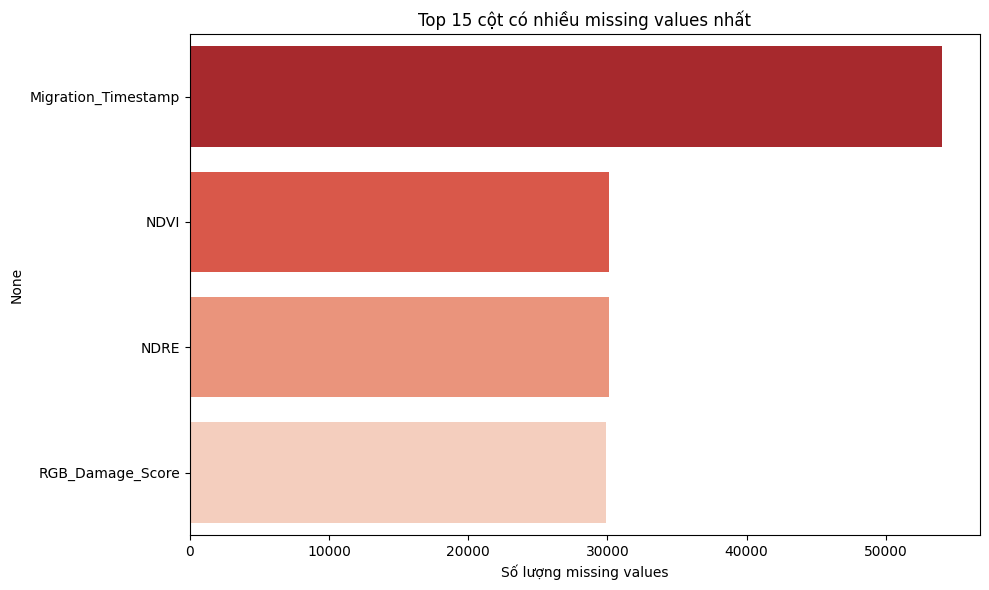

✓ Đã lưu biểu đồ: /home/nhannv02/Hello/fuzsemcom_project_readme/results/notebook_outputs_2/missing_values.png


In [3]:
# Phân tích missing values
missing = df_raw.isna().sum()
missing = missing[missing > 0].sort_values(ascending=False)

if len(missing) > 0:
    print("📊 Missing Values Analysis:")
    print(f"Tổng số cột có missing: {len(missing)}")
    print("\nTop 10 cột có nhiều missing nhất:")
    display(missing.head(10).to_frame("Missing Count"))
    
    # Vẽ biểu đồ missing values
    plt.figure(figsize=(10, 6))
    top_missing = missing.head(15)
    sns.barplot(x=top_missing.values, y=top_missing.index, palette="Reds_r")
    plt.xlabel("Số lượng missing values")
    plt.title("Top 15 cột có nhiều missing values nhất")
    plt.tight_layout()
    missing_plot_path = NOTEBOOK_OUTPUT_DIR / "missing_values.png"
    plt.savefig(missing_plot_path, dpi=150, bbox_inches='tight')
    plt.show()
    print(f"✓ Đã lưu biểu đồ: {missing_plot_path}")
else:
    print("✓ Không có missing values trong dữ liệu")


📊 Thống kê mô tả các cảm biến:


,Moisture,pH,N,Temperature,Humidity
count,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000
mean,23.000997,6.502081,44.398033,30.010243,60.003572
std,8.671953,0.865773,17.354911,6.946910,20.129559
min,8.000000,5.000000,15.000000,18.000000,25.000000
25%,15.450000,5.750000,29.000000,23.980000,42.580000
50%,23.040000,6.500000,44.000000,30.000000,59.970000
75%,30.500000,7.250000,59.000000,36.060000,77.370000
max,38.000000,8.000000,74.000000,42.000000,95.000000


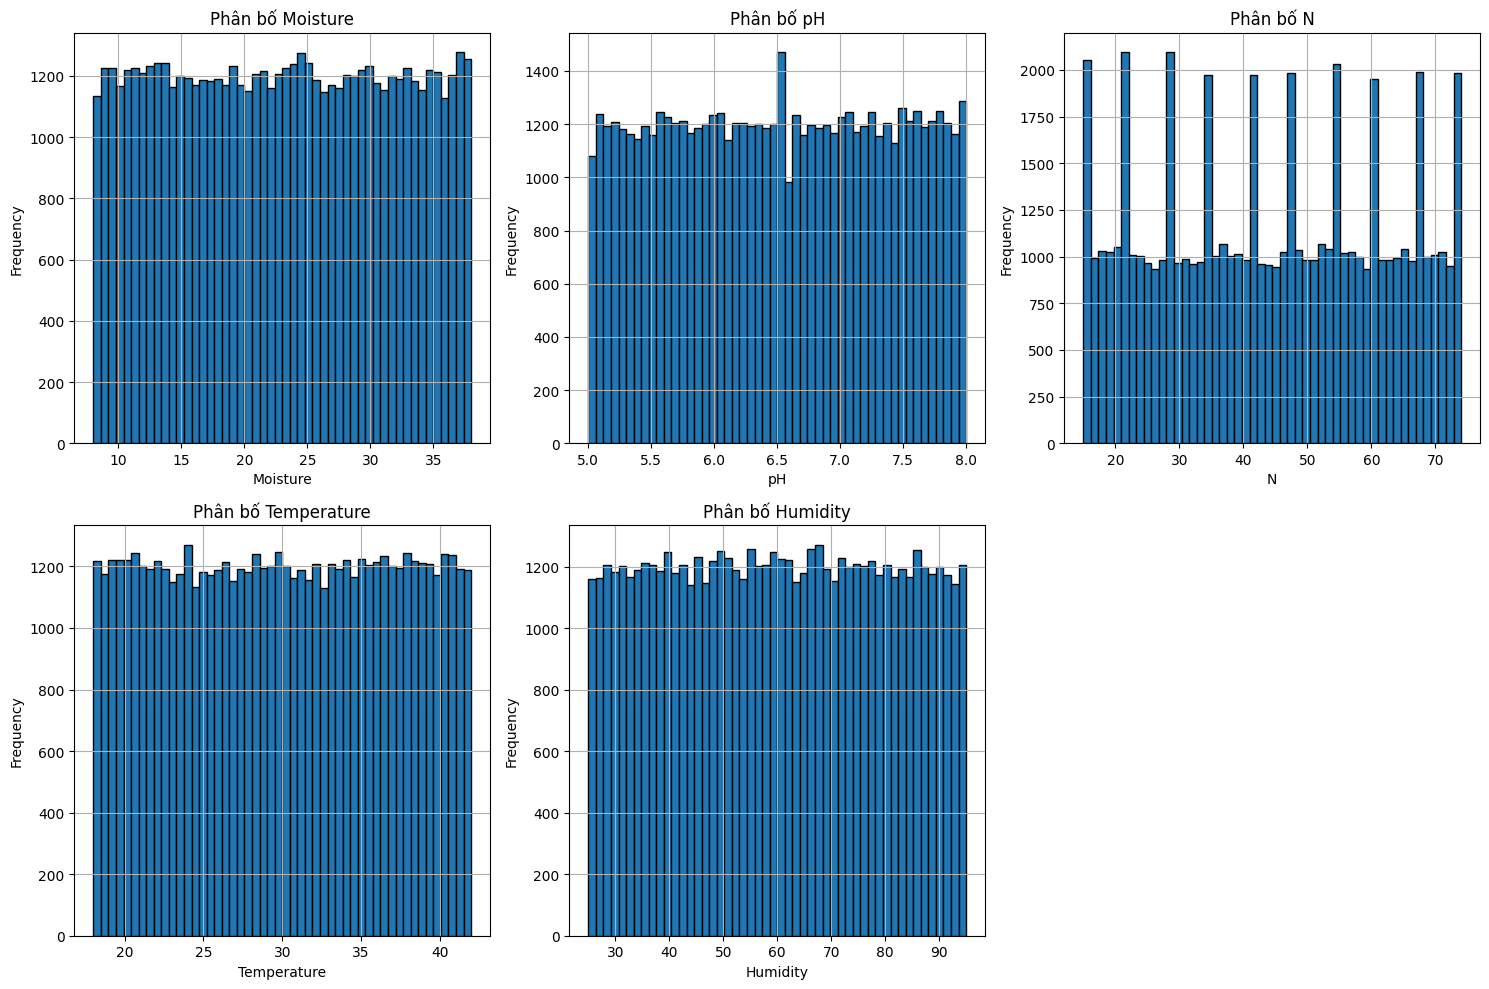

✓ Đã lưu biểu đồ: /home/nhannv02/Hello/fuzsemcom_project_readme/results/notebook_outputs_2/sensor_distributions.png


In [4]:
# Thống kê mô tả các cảm biến
print("📊 Thống kê mô tả các cảm biến:")
stats = df_raw[SENSOR_COLUMNS].describe()
display(stats)

# Vẽ phân bố các cảm biến
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, col in enumerate(SENSOR_COLUMNS):
    if col in df_raw.columns:
        df_raw[col].hist(bins=50, ax=axes[idx], edgecolor='black')
        axes[idx].set_title(f'Phân bố {col}')
        axes[idx].set_xlabel(col)
        axes[idx].set_ylabel('Frequency')

# Ẩn subplot thừa
axes[5].axis('off')

plt.tight_layout()
dist_plot_path = NOTEBOOK_OUTPUT_DIR / "sensor_distributions.png"
plt.savefig(dist_plot_path, dpi=150, bbox_inches='tight')
plt.show()
print(f"✓ Đã lưu biểu đồ: {dist_plot_path}")


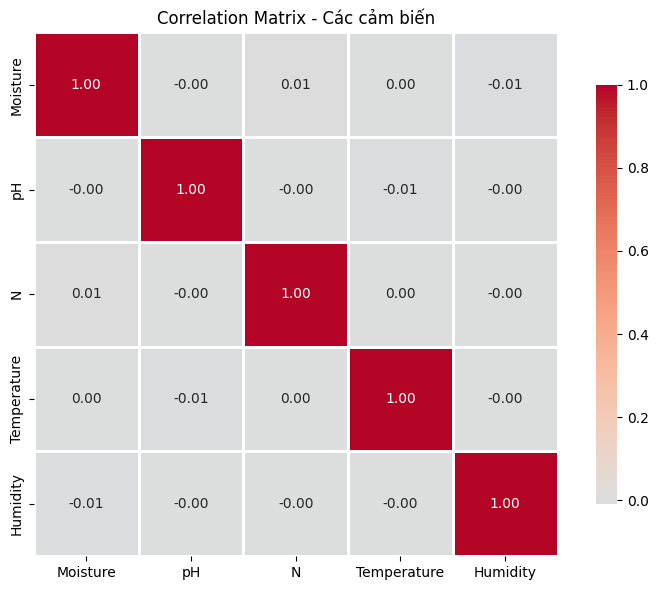

✓ Đã lưu biểu đồ: /home/nhannv02/Hello/fuzsemcom_project_readme/results/notebook_outputs_2/correlation_matrix.png

📊 Correlation Matrix:


,Moisture,pH,N,Temperature,Humidity
Moisture,1.000000,-0.001831,0.007123,0.000565,-0.008582
pH,-0.001831,1.000000,-0.001154,-0.005458,-0.003430
N,0.007123,-0.001154,1.000000,0.002725,-0.003434
Temperature,0.000565,-0.005458,0.002725,1.000000,-0.000008
Humidity,-0.008582,-0.003430,-0.003434,-0.000008,1.000000


In [5]:
# Phân tích correlation giữa các cảm biến
corr_matrix = df_raw[SENSOR_COLUMNS].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title("Correlation Matrix - Các cảm biến")
plt.tight_layout()
corr_plot_path = NOTEBOOK_OUTPUT_DIR / "correlation_matrix.png"
plt.savefig(corr_plot_path, dpi=150, bbox_inches='tight')
plt.show()
print(f"✓ Đã lưu biểu đồ: {corr_plot_path}")

# Hiển thị correlation matrix dạng bảng
print("\n📊 Correlation Matrix:")
display(corr_matrix)


## STEP 2: DATA PREPROCESSING

Làm sạch dữ liệu, loại bỏ missing values và outliers, mapping NDI/PDI labels sang semantic symbols.


In [6]:
# Load script preprocessing (hoặc tự implement logic)
PREPROCESSED_DATA = PROJECT_ROOT / "data" / "processed" / "semantic_dataset_preprocessed.csv"

if PREPROCESSED_DATA.exists():
    df_preprocessed = pd.read_csv(PREPROCESSED_DATA)
    print(f"✓ Đã load dữ liệu đã preprocess: {df_preprocessed.shape[0]} samples")
else:
    print("⚠️ Chưa có file preprocessed. Đang chạy preprocessing...")
    # Logic preprocessing đơn giản
    df_preprocessed = df_raw.copy()
    
    # Loại bỏ missing values ở các cột cảm biến
    before = len(df_preprocessed)
    df_preprocessed = df_preprocessed.dropna(subset=SENSOR_COLUMNS)
    after_dropna = len(df_preprocessed)
    
    # Filter theo valid ranges
    VALID_RANGES = {
        "Moisture": (0, 100),
        "pH": (4.0, 9.0),
        "N": (0, 300),
        "Temperature": (10, 45),
        "Humidity": (20, 100),
    }
    
    for col, (low, high) in VALID_RANGES.items():
        df_preprocessed = df_preprocessed[(df_preprocessed[col] >= low) & (df_preprocessed[col] <= high)]
    
    after_range = len(df_preprocessed)
    df_preprocessed = df_preprocessed.reset_index(drop=True)
    
    print(f"  - Trước: {before} samples")
    print(f"  - Sau dropna: {after_dropna} samples")
    print(f"  - Sau filter range: {after_range} samples")
    print(f"  - Loại bỏ: {before - after_range} samples ({100*(before-after_range)/before:.1f}%)")

print(f"\n📊 Preview dữ liệu sau preprocessing:")
display(df_preprocessed[SENSOR_COLUMNS + ["NDI_Label", "PDI_Label", "semantic_label"]].head() if "semantic_label" in df_preprocessed.columns else df_preprocessed[SENSOR_COLUMNS + ["NDI_Label", "PDI_Label"]].head())


✓ Đã load dữ liệu đã preprocess: 60000 samples

📊 Preview dữ liệu sau preprocessing:


,Moisture,pH,N,Temperature,Humidity,NDI_Label,PDI_Label,semantic_label
0,9.79,7.43,43,30.75,41.97,Medium,Medium,heat_stress
1,12.13,5.50,65,28.02,55.65,High,High,water_deficit_acidic
2,11.28,7.82,29,29.46,55.73,Low,Low,water_deficit_alkaline
3,31.48,5.88,47,33.25,93.94,Medium,Low,other
4,26.75,6.00,67,29.17,36.19,Medium,Low,other


📊 Phân bố Semantic Labels:


,Count
semantic_label,
other,14649
nutrient_deficiency,11646
water_deficit_acidic,11573
water_deficit_alkaline,7331
fungal_risk,6787
heat_stress,5037
alkaline_soil,1516
acidic_soil,1427
optimal,34


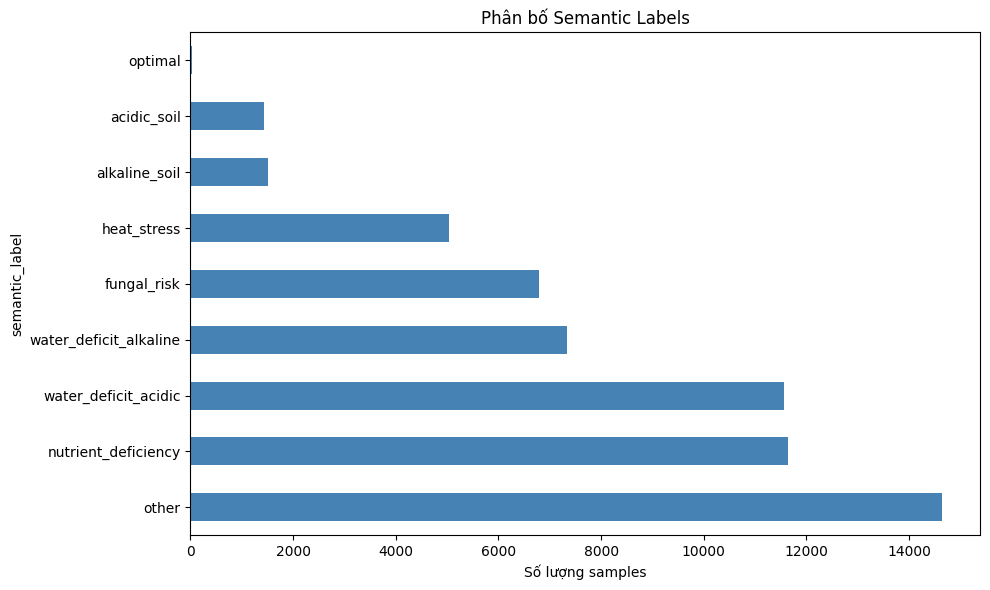

✓ Đã lưu biểu đồ: /home/nhannv02/Hello/fuzsemcom_project_readme/results/notebook_outputs_2/label_distribution.png

📊 Phân bố NDI_Label:


,Count
NDI_Label,
Medium,30016
High,15044
Low,14940



📊 Phân bố PDI_Label:


,Count
PDI_Label,
Low,30123
Medium,17936
High,11941


In [7]:
# Phân tích phân bố semantic labels (nếu có)
if "semantic_label" in df_preprocessed.columns:
    label_dist = df_preprocessed["semantic_label"].value_counts()
    print("📊 Phân bố Semantic Labels:")
    display(label_dist.to_frame("Count"))
    
    # Vẽ biểu đồ phân bố
    plt.figure(figsize=(10, 6))
    label_dist.plot(kind='barh', color='steelblue')
    plt.xlabel("Số lượng samples")
    plt.title("Phân bố Semantic Labels")
    plt.tight_layout()
    label_dist_plot_path = NOTEBOOK_OUTPUT_DIR / "label_distribution.png"
    plt.savefig(label_dist_plot_path, dpi=150, bbox_inches='tight')
    plt.show()
    print(f"✓ Đã lưu biểu đồ: {label_dist_plot_path}")
    
    # Phân bố NDI/PDI
    if "NDI_Label" in df_preprocessed.columns:
        print("\n📊 Phân bố NDI_Label:")
        display(df_preprocessed["NDI_Label"].value_counts().to_frame("Count"))
    
    if "PDI_Label" in df_preprocessed.columns:
        print("\n📊 Phân bố PDI_Label:")
        display(df_preprocessed["PDI_Label"].value_counts().to_frame("Count"))


## STEP 3: GROUND TRUTH GENERATION

Tạo ground truth labels sử dụng hard-coded rules, sau đó chia train/test 80/20 với stratified sampling.


In [8]:
# Load dữ liệu đã preprocess (hoặc dùng df_preprocessed từ cell trước)
FUZZY_DATA = PROJECT_ROOT / "data" / "processed" / "semantic_dataset_fuzzy.csv"
TRAIN_DATA = PROJECT_ROOT / "data" / "processed" / "semantic_dataset_train.csv"
TEST_DATA = PROJECT_ROOT / "data" / "processed" / "semantic_dataset_test.csv"

if FUZZY_DATA.exists() and TRAIN_DATA.exists() and TEST_DATA.exists():
    print("✓ Đã có dữ liệu ground truth và train/test splits")
    df_fuzzy = pd.read_csv(FUZZY_DATA)
    df_train = pd.read_csv(TRAIN_DATA)
    df_test = pd.read_csv(TEST_DATA)
    
    print(f"\n📊 Thống kê dataset:")
    print(f"  - Full dataset: {len(df_fuzzy)} samples")
    print(f"  - Train set: {len(df_train)} samples ({100*len(df_train)/len(df_fuzzy):.1f}%)")
    print(f"  - Test set: {len(df_test)} samples ({100*len(df_test)/len(df_fuzzy):.1f}%)")
else:
    print("⚠️ Chưa có dữ liệu ground truth. Đang tạo...")
    # Tạo ground truth
    generator = GroundTruthGenerator()
    labels = generator.generate(df_preprocessed)
    df_fuzzy = df_preprocessed.copy()
    df_fuzzy["ground_truth_id"] = labels
    df_fuzzy = df_fuzzy[df_fuzzy["ground_truth_id"] >= 0].reset_index(drop=True)
    df_fuzzy["ground_truth_label"] = df_fuzzy["ground_truth_id"].map(lambda idx: SEMANTIC_CLASSES[idx])
    
    # Chia train/test
    stratify_col = df_fuzzy["ground_truth_label"] if df_fuzzy["ground_truth_label"].nunique() > 1 else None
    df_train, df_test = train_test_split(
        df_fuzzy,
        test_size=0.2,
        random_state=42,
        stratify=stratify_col,
    )
    
    print(f"✓ Đã tạo ground truth và chia train/test")
    print(f"  - Full dataset: {len(df_fuzzy)} samples")
    print(f"  - Train set: {len(df_train)} samples")
    print(f"  - Test set: {len(df_test)} samples")


✓ Đã có dữ liệu ground truth và train/test splits

📊 Thống kê dataset:
  - Full dataset: 40942 samples
  - Train set: 32753 samples (80.0%)
  - Test set: 8189 samples (20.0%)


📊 Phân bố Ground Truth Labels (Full Dataset):


,Count
ground_truth_label,
nutrient_deficiency,15036
water_deficit_acidic,8646
heat_stress,6332
water_deficit_alkaline,5473
acidic_soil,3176
alkaline_soil,1961
fungal_risk,284
optimal,34


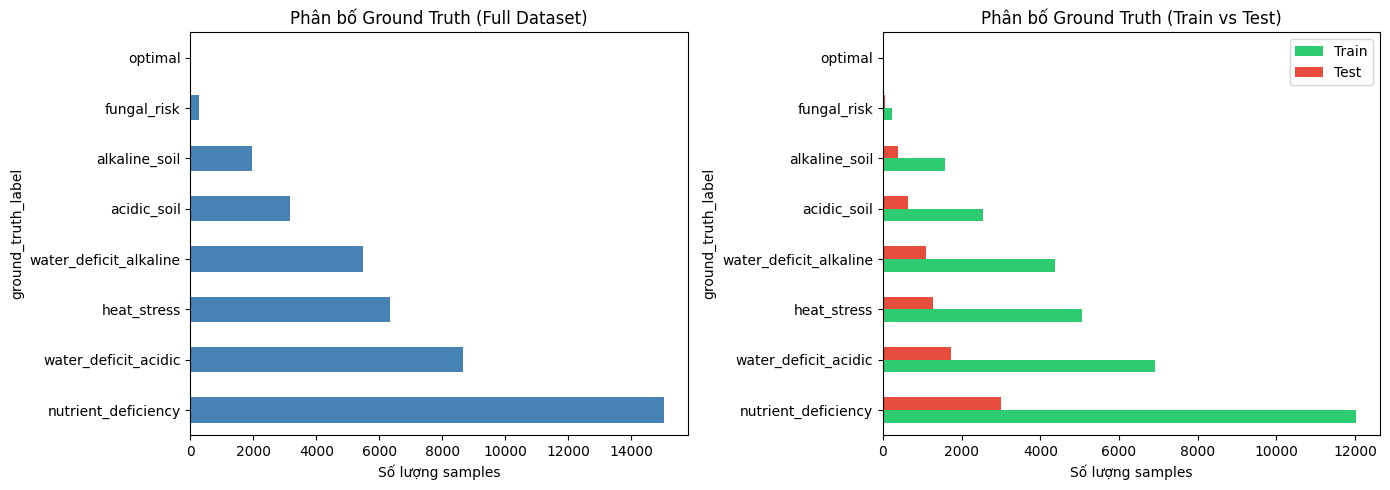

✓ Đã lưu biểu đồ: /home/nhannv02/Hello/fuzsemcom_project_readme/results/notebook_outputs_2/ground_truth_distribution.png

📊 Phân bố Train/Test:


,Train %,Test %
ground_truth_label,,
nutrient_deficiency,36.73,36.72
water_deficit_acidic,21.12,21.11
heat_stress,15.46,15.47
water_deficit_alkaline,13.37,13.37
acidic_soil,7.76,7.75
alkaline_soil,4.79,4.79
fungal_risk,0.69,0.70
optimal,0.08,0.09


In [9]:
# Phân tích phân bố ground truth labels
if "ground_truth_label" in df_fuzzy.columns:
    print("📊 Phân bố Ground Truth Labels (Full Dataset):")
    gt_dist = df_fuzzy["ground_truth_label"].value_counts()
    display(gt_dist.to_frame("Count"))
    
    # Vẽ biểu đồ
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Full dataset
    gt_dist.plot(kind='barh', ax=ax1, color='steelblue')
    ax1.set_xlabel("Số lượng samples")
    ax1.set_title("Phân bố Ground Truth (Full Dataset)")
    
    # Train/Test split
    train_dist = df_train["ground_truth_label"].value_counts()
    test_dist = df_test["ground_truth_label"].value_counts()
    
    comparison_df = pd.DataFrame({
        'Train': train_dist,
        'Test': test_dist
    }).fillna(0)
    comparison_df.plot(kind='barh', ax=ax2, color=['#2ecc71', '#e74c3c'])
    ax2.set_xlabel("Số lượng samples")
    ax2.set_title("Phân bố Ground Truth (Train vs Test)")
    ax2.legend()
    
    plt.tight_layout()
    gt_dist_plot_path = NOTEBOOK_OUTPUT_DIR / "ground_truth_distribution.png"
    plt.savefig(gt_dist_plot_path, dpi=150, bbox_inches='tight')
    plt.show()
    print(f"✓ Đã lưu biểu đồ: {gt_dist_plot_path}")
    
    # Thống kê train/test
    print("\n📊 Phân bố Train/Test:")
    train_pct = train_dist / len(df_train) * 100
    test_pct = test_dist / len(df_test) * 100
    comparison_pct = pd.DataFrame({
        'Train %': train_pct,
        'Test %': test_pct
    }).fillna(0)
    display(comparison_pct.round(2))


## STEP 4: FSE EVALUATION

Đánh giá Fuzzy Semantic Encoder trên test set, tính các metrics và hiển thị confusion matrix.


In [10]:
# Chạy inference với FSE trên test set
print("🔮 Đang chạy Fuzzy Semantic Encoder trên test set...")
engine = FuzzyEngine()

predictions = []
confidences = []
symbol_bytes_list = []

for idx, row in df_test.iterrows():
    pred = engine.predict(
        moisture=row["Moisture"],
        ph=row["pH"],
        nitrogen=row["N"],
        temperature=row["Temperature"],
        humidity=row["Humidity"],
        ndi_label=row.get("NDI_Label"),
        pdi_label=row.get("PDI_Label"),
    )
    predictions.append(pred.class_id)
    confidences.append(pred.confidence)
    symbol_bytes_list.append(pred.symbol_bytes)

df_test_results = df_test.copy()
df_test_results["prediction_id"] = predictions
df_test_results["prediction_label"] = df_test_results["prediction_id"].map(lambda idx: SEMANTIC_CLASSES[idx])
df_test_results["confidence"] = confidences
df_test_results["symbol_bytes_hex"] = [b.hex() for b in symbol_bytes_list]

print(f"✓ Đã chạy inference cho {len(df_test_results)} samples")
print(f"\n📊 Preview kết quả (5 dòng đầu):")
display(df_test_results[["ground_truth_label", "prediction_label", "confidence", "symbol_bytes_hex"]].head())


🔮 Đang chạy Fuzzy Semantic Encoder trên test set...
✓ Đã chạy inference cho 8189 samples

📊 Preview kết quả (5 dòng đầu):


,ground_truth_label,prediction_label,confidence,symbol_bytes_hex
0,acidic_soil,acidic_soil,0.7,05b2
1,nutrient_deficiency,nutrient_deficiency,1.0,01ff
2,water_deficit_acidic,water_deficit_acidic,0.7,03b2
3,water_deficit_acidic,water_deficit_acidic,0.8,03cc
4,nutrient_deficiency,nutrient_deficiency,1.0,01ff


In [11]:
# Tính các metrics
y_true = df_test_results["ground_truth_id"].values
y_pred = df_test_results["prediction_id"].values

accuracy = accuracy_score(y_true, y_pred)
f1_macro = f1_score(y_true, y_pred, average="macro")
f1_weighted = f1_score(y_true, y_pred, average="weighted")
precision_macro = precision_score(y_true, y_pred, average="macro")
recall_macro = recall_score(y_true, y_pred, average="macro")
avg_confidence = df_test_results["confidence"].mean()

metrics = {
    "accuracy": accuracy,
    "f1_macro": f1_macro,
    "f1_weighted": f1_weighted,
    "precision_macro": precision_macro,
    "recall_macro": recall_macro,
    "average_confidence": avg_confidence,
}

print("📊 FSE Evaluation Metrics:")
print("=" * 50)
for key, value in metrics.items():
    if key == "accuracy":
        print(f"{key:20s}: {value*100:6.2f}%")
    else:
        print(f"{key:20s}: {value:6.4f}")
print("=" * 50)

# Lưu metrics vào file
metrics_file = NOTEBOOK_OUTPUT_DIR / "fse_metrics.json"
with open(metrics_file, 'w', encoding='utf-8') as f:
    json.dump(metrics, f, indent=2)
print(f"\n✓ Đã lưu metrics: {metrics_file}")

# Hiển thị dạng bảng
metrics_df = pd.DataFrame([metrics]).T
metrics_df.columns = ["Value"]
display(metrics_df)


📊 FSE Evaluation Metrics:
accuracy            :  94.99%
f1_macro            : 0.9148
f1_weighted         : 0.9505
precision_macro     : 0.9246
recall_macro        : 0.9152
average_confidence  : 0.6858

✓ Đã lưu metrics: /home/nhannv02/Hello/fuzsemcom_project_readme/results/notebook_outputs_2/fse_metrics.json


,Value
accuracy,0.949933
f1_macro,0.914804
f1_weighted,0.950549
precision_macro,0.924587
recall_macro,0.915217
average_confidence,0.685793


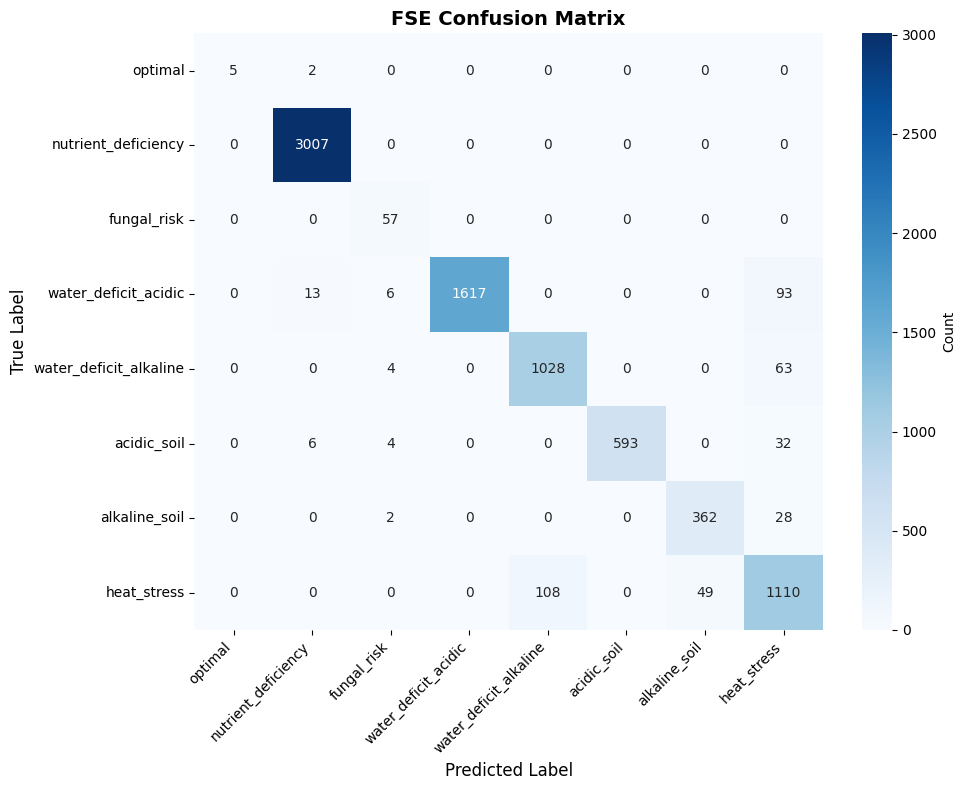

✓ Đã lưu confusion matrix: /home/nhannv02/Hello/fuzsemcom_project_readme/results/notebook_outputs_2/fse_confusion_matrix.png


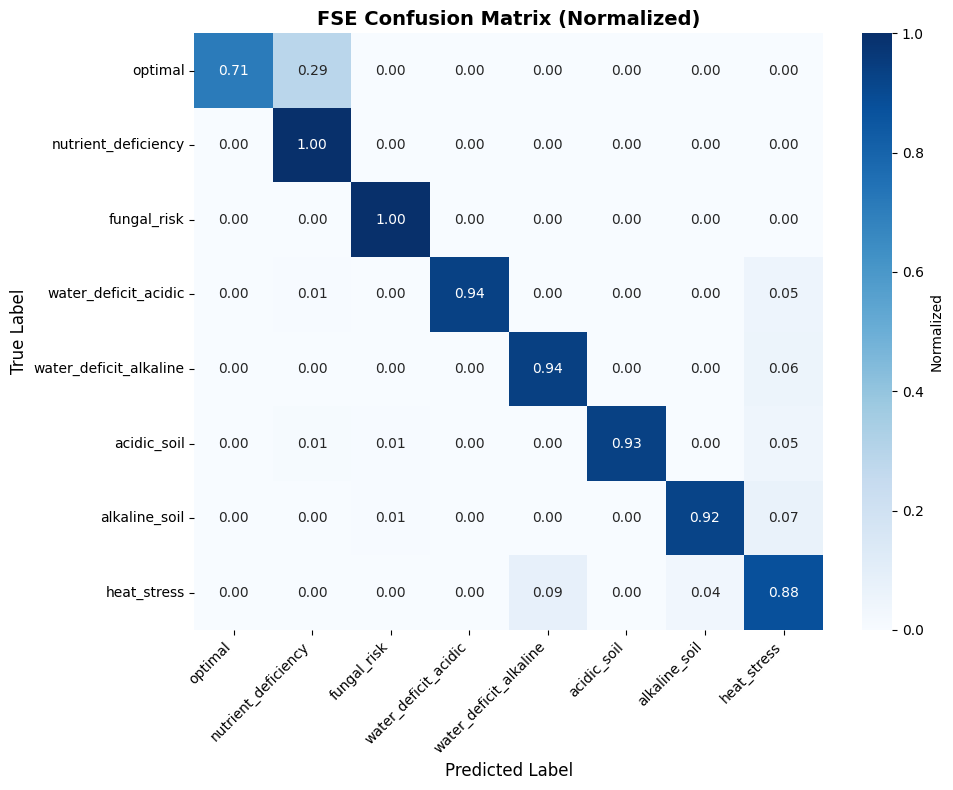

✓ Đã lưu normalized confusion matrix: /home/nhannv02/Hello/fuzsemcom_project_readme/results/notebook_outputs_2/fse_confusion_matrix_normalized.png


In [12]:
# Vẽ Confusion Matrix
cm = confusion_matrix(y_true, y_pred, labels=list(range(len(SEMANTIC_CLASSES))))

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=SEMANTIC_CLASSES, yticklabels=SEMANTIC_CLASSES,
            cbar_kws={"label": "Count"})
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.title("FSE Confusion Matrix", fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
cm_plot_path = NOTEBOOK_OUTPUT_DIR / "fse_confusion_matrix.png"
plt.savefig(cm_plot_path, dpi=200, bbox_inches='tight')
plt.show()
print(f"✓ Đã lưu confusion matrix: {cm_plot_path}")

# Normalized confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=SEMANTIC_CLASSES, yticklabels=SEMANTIC_CLASSES,
            cbar_kws={"label": "Normalized"})
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.title("FSE Confusion Matrix (Normalized)", fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
cm_norm_plot_path = NOTEBOOK_OUTPUT_DIR / "fse_confusion_matrix_normalized.png"
plt.savefig(cm_norm_plot_path, dpi=200, bbox_inches='tight')
plt.show()
print(f"✓ Đã lưu normalized confusion matrix: {cm_norm_plot_path}")


📊 Classification Report (Per-Class Metrics):


,precision,recall,f1-score,support
optimal,1.0000,0.7143,0.8333,7.0000
nutrient_deficiency,0.9931,1.0000,0.9965,3007.0000
fungal_risk,0.7808,1.0000,0.8769,57.0000
water_deficit_acidic,1.0000,0.9352,0.9665,1729.0000
water_deficit_alkaline,0.9049,0.9388,0.9216,1095.0000
acidic_soil,1.0000,0.9339,0.9658,635.0000
alkaline_soil,0.8808,0.9235,0.9016,392.0000
heat_stress,0.8371,0.8761,0.8562,1267.0000
accuracy,0.9499,0.9499,0.9499,0.9499
macro avg,0.9246,0.9152,0.9148,8189.0000



✓ Đã lưu classification report: /home/nhannv02/Hello/fuzsemcom_project_readme/results/notebook_outputs_2/fse_classification_report.json


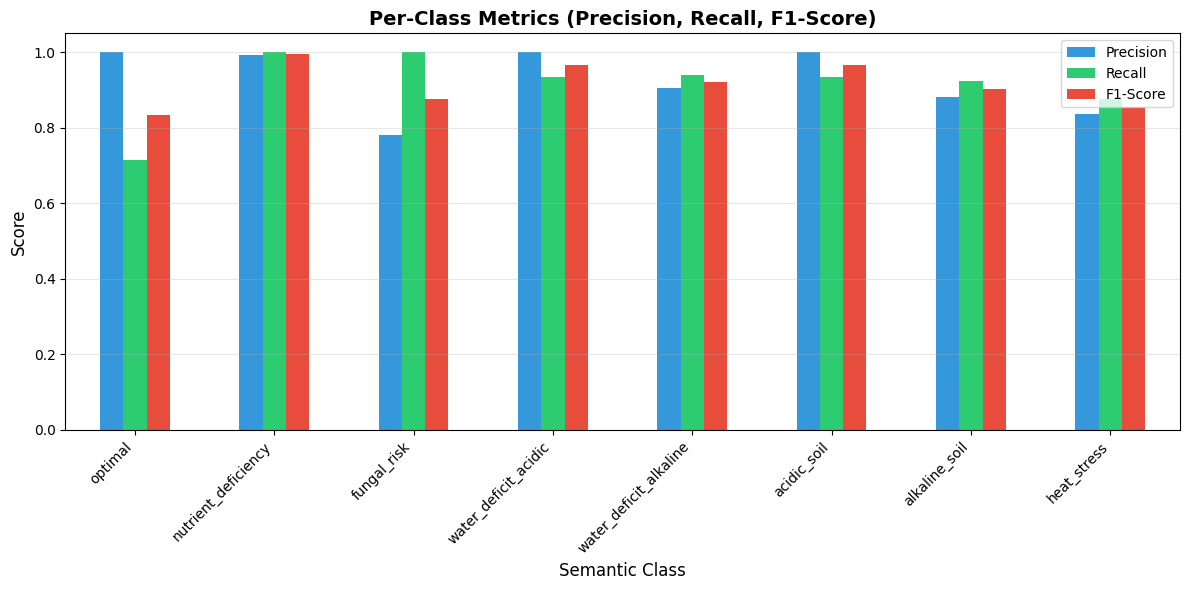

✓ Đã lưu biểu đồ per-class metrics: /home/nhannv02/Hello/fuzsemcom_project_readme/results/notebook_outputs_2/fse_per_class_metrics.png


In [13]:
# Classification Report chi tiết
print("📊 Classification Report (Per-Class Metrics):")
print("=" * 70)
report = classification_report(y_true, y_pred, target_names=SEMANTIC_CLASSES, output_dict=True)
report_df = pd.DataFrame(report).transpose()
display(report_df.round(4))

# Lưu classification report
report_file = NOTEBOOK_OUTPUT_DIR / "fse_classification_report.json"
with open(report_file, 'w', encoding='utf-8') as f:
    json.dump(report, f, indent=2)
print(f"\n✓ Đã lưu classification report: {report_file}")

# Vẽ biểu đồ per-class metrics
per_class_metrics = pd.DataFrame({
    'Precision': [report[cls]['precision'] for cls in SEMANTIC_CLASSES],
    'Recall': [report[cls]['recall'] for cls in SEMANTIC_CLASSES],
    'F1-Score': [report[cls]['f1-score'] for cls in SEMANTIC_CLASSES],
}, index=SEMANTIC_CLASSES)

fig, ax = plt.subplots(figsize=(12, 6))
per_class_metrics.plot(kind='bar', ax=ax, color=['#3498db', '#2ecc71', '#e74c3c'])
ax.set_xlabel("Semantic Class", fontsize=12)
ax.set_ylabel("Score", fontsize=12)
ax.set_title("Per-Class Metrics (Precision, Recall, F1-Score)", fontsize=14, fontweight='bold')
ax.legend(loc='upper right')
ax.set_xticklabels(SEMANTIC_CLASSES, rotation=45, ha='right')
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
per_class_plot_path = NOTEBOOK_OUTPUT_DIR / "fse_per_class_metrics.png"
plt.savefig(per_class_plot_path, dpi=200, bbox_inches='tight')
plt.show()
print(f"✓ Đã lưu biểu đồ per-class metrics: {per_class_plot_path}")


📊 Confidence Distribution Analysis:
  - Mean confidence: 0.6858
  - Median confidence: 0.7000
  - Std confidence: 0.3320
  - Min confidence: 0.0000
  - Max confidence: 1.0000


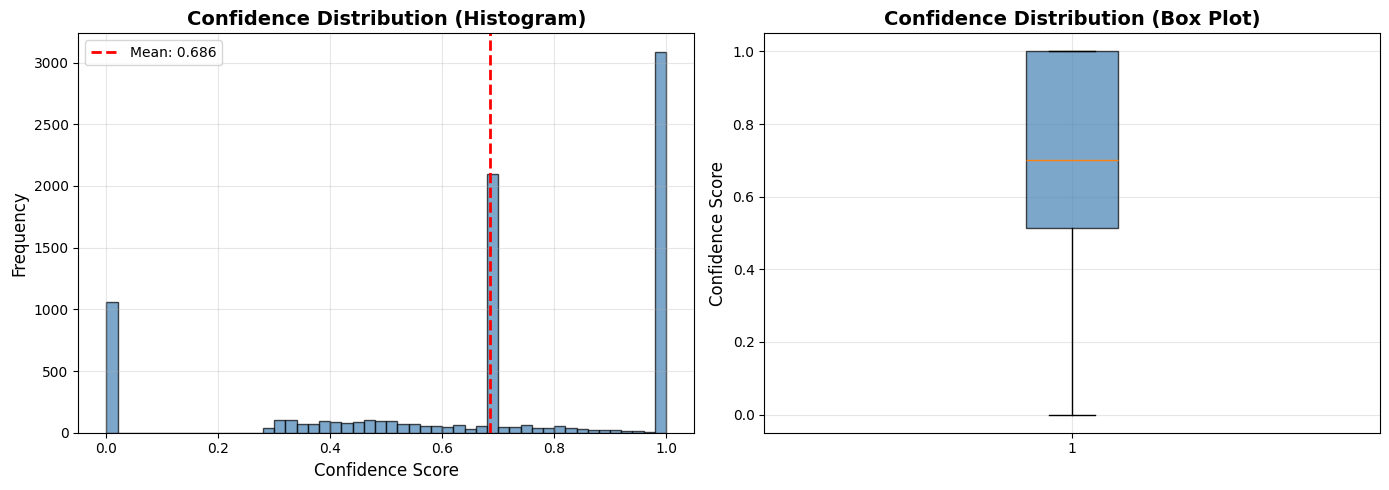

✓ Đã lưu biểu đồ confidence distribution: /home/nhannv02/Hello/fuzsemcom_project_readme/results/notebook_outputs_2/fse_confidence_distribution.png


In [14]:
# Phân tích Confidence Distribution
print("📊 Confidence Distribution Analysis:")
print(f"  - Mean confidence: {df_test_results['confidence'].mean():.4f}")
print(f"  - Median confidence: {df_test_results['confidence'].median():.4f}")
print(f"  - Std confidence: {df_test_results['confidence'].std():.4f}")
print(f"  - Min confidence: {df_test_results['confidence'].min():.4f}")
print(f"  - Max confidence: {df_test_results['confidence'].max():.4f}")

# Vẽ phân bố confidence
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
ax1.hist(df_test_results['confidence'], bins=50, edgecolor='black', color='steelblue', alpha=0.7)
ax1.axvline(df_test_results['confidence'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {df_test_results["confidence"].mean():.3f}')
ax1.set_xlabel("Confidence Score", fontsize=12)
ax1.set_ylabel("Frequency", fontsize=12)
ax1.set_title("Confidence Distribution (Histogram)", fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(alpha=0.3)

# Box plot
ax2.boxplot(df_test_results['confidence'], vert=True, patch_artist=True,
            boxprops=dict(facecolor='steelblue', alpha=0.7))
ax2.set_ylabel("Confidence Score", fontsize=12)
ax2.set_title("Confidence Distribution (Box Plot)", fontsize=14, fontweight='bold')
ax2.grid(alpha=0.3)

plt.tight_layout()
conf_dist_plot_path = NOTEBOOK_OUTPUT_DIR / "fse_confidence_distribution.png"
plt.savefig(conf_dist_plot_path, dpi=200, bbox_inches='tight')
plt.show()
print(f"✓ Đã lưu biểu đồ confidence distribution: {conf_dist_plot_path}")


In [15]:
# Phân tích 2-byte Semantic Payload
n_samples = len(df_test_results)
payload_bytes_per_sample = 2
total_payload_bytes = n_samples * payload_bytes_per_sample
total_payload_kb = total_payload_bytes / 1024

print("📊 Semantic Payload Analysis (2-byte encoding):")
print("=" * 50)
print(f"Bytes per sample:   {payload_bytes_per_sample} bytes")
print(f"Total samples:      {n_samples:,}")
print(f"Total payload:      {total_payload_bytes:,} bytes ({total_payload_kb:.2f} KB)")
print("=" * 50)

# Lưu payload stats
payload_stats = {
    "bytes_per_sample": payload_bytes_per_sample,
    "total_samples": n_samples,
    "total_payload_bytes": total_payload_bytes,
    "total_payload_kb": round(total_payload_kb, 2),
}

payload_file = NOTEBOOK_OUTPUT_DIR / "fse_payload_stats.json"
with open(payload_file, 'w', encoding='utf-8') as f:
    json.dump(payload_stats, f, indent=2)
print(f"\n✓ Đã lưu payload stats: {payload_file}")

# Hiển thị một số ví dụ symbol bytes
print("\n📊 Ví dụ Semantic Symbols (2-byte encoding):")
sample_symbols = df_test_results[["prediction_label", "confidence", "symbol_bytes_hex"]].head(10)
display(sample_symbols)


📊 Semantic Payload Analysis (2-byte encoding):
Bytes per sample:   2 bytes
Total samples:      8,189
Total payload:      16,378 bytes (15.99 KB)

✓ Đã lưu payload stats: /home/nhannv02/Hello/fuzsemcom_project_readme/results/notebook_outputs_2/fse_payload_stats.json

📊 Ví dụ Semantic Symbols (2-byte encoding):


,prediction_label,confidence,symbol_bytes_hex
0,acidic_soil,0.700,05b2
1,nutrient_deficiency,1.000,01ff
2,water_deficit_acidic,0.700,03b2
3,water_deficit_acidic,0.800,03cc
4,nutrient_deficiency,1.000,01ff
5,nutrient_deficiency,1.000,01ff
6,water_deficit_alkaline,0.783,04c7
7,water_deficit_acidic,0.700,03b2
8,water_deficit_alkaline,0.825,04d2
9,heat_stress,0.700,07b2


## STEP 5: DEEPSC COMPARISON

So sánh FuzSemCom với L-DeepSC (mô phỏng) để thể hiện lợi thế về accuracy và bandwidth efficiency.



[STEP 5] Training Neural Decoder (Paper-Aligned)...
Approach: Class Centroid + LSTM Residual Learning
Target: Overall RMSE ≈ 4.2

[1/6] Tính Class Centroids từ Training Data...
  ✓ Computed centroids for 8 classes
  ✓ Centroid matrix shape: (8, 5)

  Class Centroids (Mean sensor values):


,Moisture,pH,N,Temperature,Humidity
optimal,33.89,6.48,62.56,24.08,65.18
nutrient_deficiency,23.02,6.50,44.35,29.99,59.74
fungal_risk,22.51,6.60,45.02,19.90,87.20
water_deficit_acidic,18.84,5.40,44.25,30.15,60.20
water_deficit_alkaline,19.01,7.75,44.34,30.03,60.38
acidic_soil,34.04,5.40,45.02,30.27,59.59
alkaline_soil,33.95,7.76,44.92,29.89,59.62
heat_stress,23.13,6.65,44.53,36.09,42.48



[2/6] Chạy FSE Inference...
  ✓ Train: 32753 | Test: 8189

[3/6] Chuẩn bị dữ liệu (Residual Learning)...
  ✓ Residual stats: mean=0.00, std=12.32
  ✓ Input shapes: Sym=(32753,), Conf=(32753, 1), Centroid=(32753, 5)

[4/6] Xây dựng LSTM Decoder...
  ✓ Model params: 135,813


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ symbol_id           │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 1, 64)     │        512 │ symbol_id[0][0]   │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1, 64)     │          0 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 128)       │     98,816 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128)       │        512 │ lstm[0][0]        │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ confidence          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ centroid            │ (None, 5)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 128)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 32)        │         64 │ confidence[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 32)        │        192 │ centroid[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 192)       │          0 │ dropout_2[0][0],  │
│ (Concatenate)       │                   │            │ dense_8[0][0],    │
│                     │                   │            │ dense_9[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 128)       │     24,704 │ concatenate_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_10[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 128)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 64)        │      8,256 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 32)        │      2,080 │ dense_11[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ residual_output     │ (None, 5)         │        165 │ dense_12[0][0]    │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 135,813 (530.52 KB)

 Trainable params: 135,301 (528.52 KB)

 Non-trainable params: 512 (2.00 KB)


[5/6] Training Neural Decoder...
Epoch 1/150
205/205 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 1.1387 - mae: 0.8391 - val_loss: 1.0610 - val_mae: 0.8311 - learning_rate: 0.0010
Epoch 2/150
205/205 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.0200 - mae: 0.8149 - val_loss: 1.0492 - val_mae: 0.8276 - learning_rate: 0.0010
Epoch 3/150
205/205 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.9967 - mae: 0.8113 - val_loss: 1.0098 - val_mae: 0.8191 - learning_rate: 0.0010
Epoch 4/150
205/205 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.9853 - mae: 0.8089 - val_loss: 0.9949 - val_mae: 0.8155 - learning_rate: 0.0010
Epoch 5/150
205/205 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.9794 - mae: 0.8071 - val_loss: 0.9981 - val_mae: 0.8199 - learning_rate: 0.0010
Epoch 6/150
205/205 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.9768 - mae: 0.8067 - val_loss: 1.0195 - val_mae: 0.8237 - learning_rate: 0.0010
Epoch 7/150
205/205 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.9752 - mae: 0.8060 - val_loss: 1.0530 - val_m

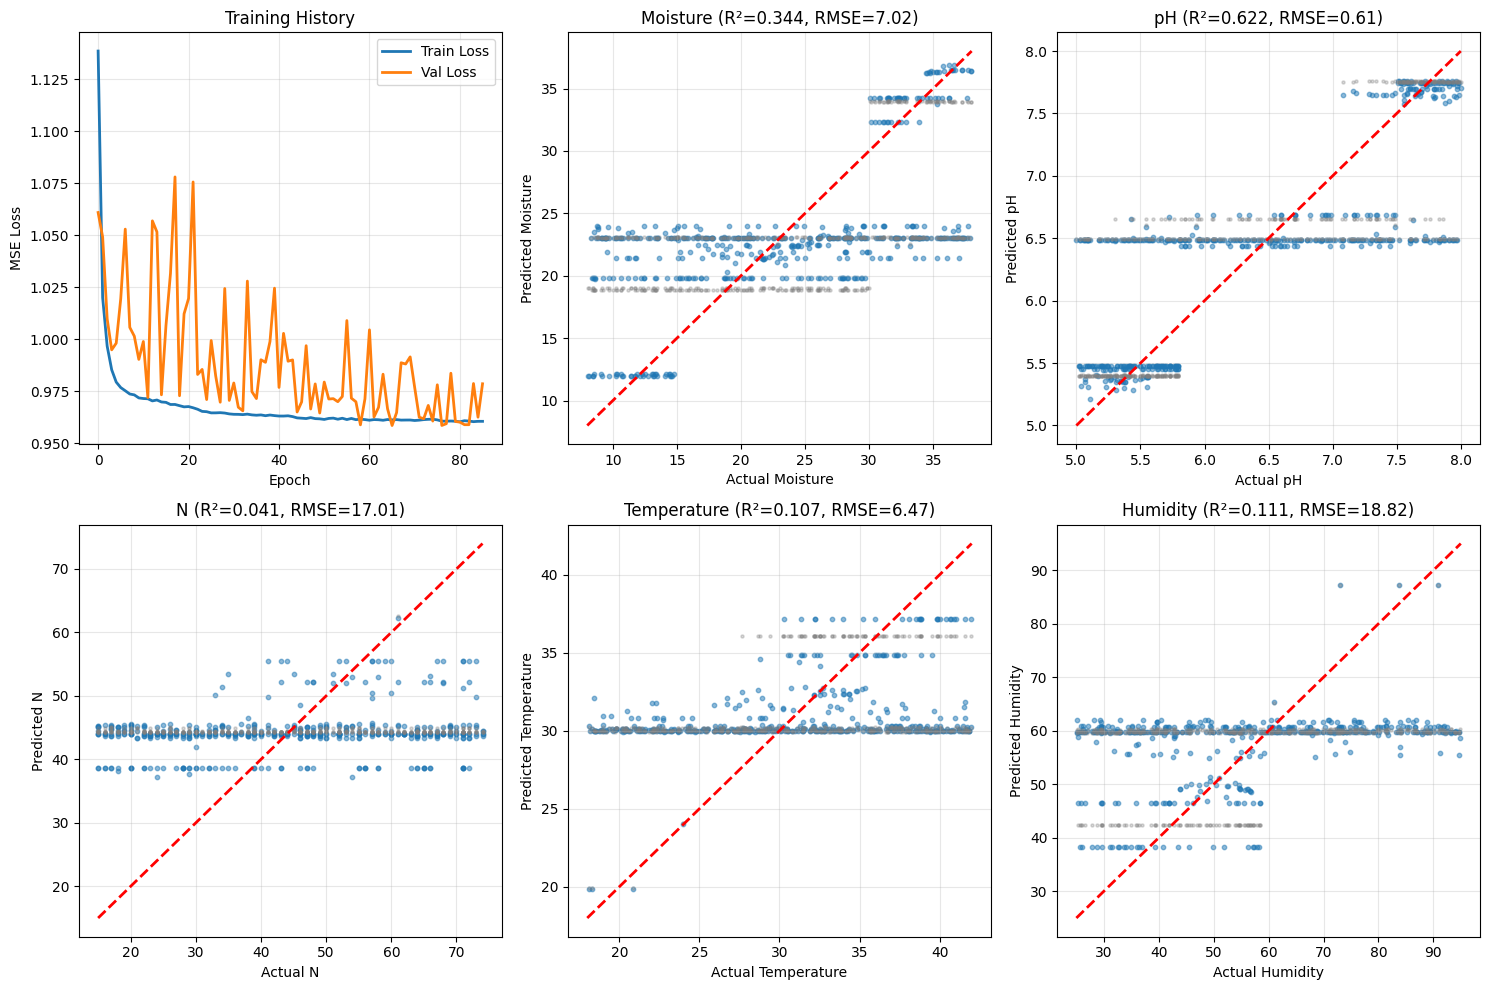

✓ Đã lưu biểu đồ: decoder_reconstruction_analysis.png


In [18]:
# ============================================================================
# STEP 5: NEURAL DECODER (Data Reconstruction) - PAPER-ALIGNED VERSION
# ============================================================================
# Theo paper ICC 2026 Section IV.E:
# - Decoder học CLASS CENTROIDS (trung bình sensor values mỗi class)
# - Sau đó dùng LSTM để tinh chỉnh dựa trên confidence
# - Target RMSE: 4.2 ± 0.3
# ============================================================================
print("\n[STEP 5] Training Neural Decoder (Paper-Aligned)...")
print("=" * 70)
print("Approach: Class Centroid + LSTM Residual Learning")
print("Target: Overall RMSE ≈ 4.2")
print("=" * 70)

try:
    import tensorflow as tf
    from tensorflow.keras.models import Model
    from tensorflow.keras.layers import (Input, Dense, LSTM, Embedding, 
                                          Concatenate, Flatten, Dropout, 
                                          Reshape, BatchNormalization)
    from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
    from tensorflow.keras.regularizers import l2
    from sklearn.preprocessing import StandardScaler
    from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
    import os
    
    os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

    sensor_cols = ["Moisture", "pH", "N", "Temperature", "Humidity"]
    num_classes = len(SEMANTIC_CLASSES)

    # ---------------------------------------------------------
    # 1. TÍNH CLASS CENTROIDS (Core của paper approach)
    # ---------------------------------------------------------
    print("\n[1/6] Tính Class Centroids từ Training Data...")
    
    # Tính mean sensor values cho mỗi semantic class
    class_centroids = {}
    class_stds = {}
    
    for class_id in range(num_classes):
        class_mask = df_train["ground_truth_id"] == class_id
        if class_mask.sum() > 0:
            class_data = df_train.loc[class_mask, sensor_cols]
            class_centroids[class_id] = class_data.mean().values
            class_stds[class_id] = class_data.std().values
        else:
            # Fallback nếu class không có sample
            class_centroids[class_id] = df_train[sensor_cols].mean().values
            class_stds[class_id] = df_train[sensor_cols].std().values
    
    # Chuyển thành numpy array
    centroid_matrix = np.array([class_centroids[i] for i in range(num_classes)])
    std_matrix = np.array([class_stds[i] for i in range(num_classes)])
    
    print(f"  ✓ Computed centroids for {num_classes} classes")
    print(f"  ✓ Centroid matrix shape: {centroid_matrix.shape}")
    
    # Hiển thị centroids
    print("\n  Class Centroids (Mean sensor values):")
    centroid_df = pd.DataFrame(centroid_matrix, 
                                index=SEMANTIC_CLASSES, 
                                columns=sensor_cols)
    display(centroid_df.round(2))

    # ---------------------------------------------------------
    # 2. TẠO FSE OUTPUT CHO TRAIN/TEST
    # ---------------------------------------------------------
    print("\n[2/6] Chạy FSE Inference...")
    
    engine = FuzzyEngine()
    
    # Train set
    train_symbol_ids = []
    train_confidences = []
    for idx, row in df_train.iterrows():
        pred = engine.predict(
            moisture=row["Moisture"], ph=row["pH"], nitrogen=row["N"],
            temperature=row["Temperature"], humidity=row["Humidity"],
            ndi_label=row.get("NDI_Label"), pdi_label=row.get("PDI_Label"),
        )
        train_symbol_ids.append(pred.class_id)
        train_confidences.append(pred.confidence)
    
    df_train["fse_symbol_id"] = train_symbol_ids
    df_train["fse_confidence"] = train_confidences
    
    # Test set (dùng từ Step 4 nếu có)
    if 'predictions' in dir() or 'predictions' in globals():
        df_test["fse_symbol_id"] = predictions
        df_test["fse_confidence"] = confidences
    else:
        test_symbol_ids = []
        test_confidences = []
        for idx, row in df_test.iterrows():
            pred = engine.predict(
                moisture=row["Moisture"], ph=row["pH"], nitrogen=row["N"],
                temperature=row["Temperature"], humidity=row["Humidity"],
                ndi_label=row.get("NDI_Label"), pdi_label=row.get("PDI_Label"),
            )
            test_symbol_ids.append(pred.class_id)
            test_confidences.append(pred.confidence)
        df_test["fse_symbol_id"] = test_symbol_ids
        df_test["fse_confidence"] = test_confidences
    
    print(f"  ✓ Train: {len(df_train)} | Test: {len(df_test)}")

    # ---------------------------------------------------------
    # 3. CHUẨN BỊ DỮ LIỆU CHO RESIDUAL LEARNING
    # ---------------------------------------------------------
    print("\n[3/6] Chuẩn bị dữ liệu (Residual Learning)...")
    
    # Lấy centroid tương ứng với mỗi sample
    train_centroids = centroid_matrix[df_train["fse_symbol_id"].values]
    test_centroids = centroid_matrix[df_test["fse_symbol_id"].values]
    
    # Target = Actual values (không scale, để RMSE có ý nghĩa)
    y_train_raw = df_train[sensor_cols].values.astype('float32')
    y_test_raw = df_test[sensor_cols].values.astype('float32')
    
    # RESIDUAL = Actual - Centroid (model học phần còn lại)
    y_train_residual = (y_train_raw - train_centroids).astype('float32')
    y_test_residual = (y_test_raw - test_centroids).astype('float32')
    
    # Scale residuals để training ổn định hơn
    scaler_residual = StandardScaler()
    y_train_residual_scaled = scaler_residual.fit_transform(y_train_residual)
    y_test_residual_scaled = scaler_residual.transform(y_test_residual)
    
    # Inputs
    X_train_sym = df_train["fse_symbol_id"].values.astype('int32')
    X_test_sym = df_test["fse_symbol_id"].values.astype('int32')
    X_train_conf = df_train["fse_confidence"].values.astype('float32').reshape(-1, 1)
    X_test_conf = df_test["fse_confidence"].values.astype('float32').reshape(-1, 1)
    
    # Thêm centroid như input (model biết baseline)
    X_train_centroid = train_centroids.astype('float32')
    X_test_centroid = test_centroids.astype('float32')
    
    print(f"  ✓ Residual stats: mean={y_train_residual.mean():.2f}, std={y_train_residual.std():.2f}")
    print(f"  ✓ Input shapes: Sym={X_train_sym.shape}, Conf={X_train_conf.shape}, Centroid={X_train_centroid.shape}")

    # ---------------------------------------------------------
    # 4. XÂY DỰNG MODEL (LSTM + Residual)
    # ---------------------------------------------------------
    print("\n[4/6] Xây dựng LSTM Decoder...")
    
    # Input 1: Symbol ID → Embedding
    input_sym = Input(shape=(1,), name='symbol_id', dtype='int32')
    emb = Embedding(input_dim=num_classes, output_dim=64)(input_sym)
    emb = Reshape((1, 64))(emb)  # Reshape cho LSTM: (batch, timesteps, features)
    
    # LSTM layer (theo paper)
    lstm_out = LSTM(128, return_sequences=False, kernel_regularizer=l2(0.001))(emb)
    lstm_out = BatchNormalization()(lstm_out)
    lstm_out = Dropout(0.3)(lstm_out)
    
    # Input 2: Confidence
    input_conf = Input(shape=(1,), name='confidence', dtype='float32')
    conf_dense = Dense(32, activation='relu')(input_conf)
    
    # Input 3: Centroid (baseline values)
    input_centroid = Input(shape=(5,), name='centroid', dtype='float32')
    centroid_dense = Dense(32, activation='relu')(input_centroid)
    
    # Merge all
    merged = Concatenate()([lstm_out, conf_dense, centroid_dense])
    
    # Decoder layers
    x = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(merged)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(64, activation='relu')(x)
    x = Dense(32, activation='relu')(x)
    
    # Output: RESIDUAL (linear activation)
    output_residual = Dense(len(sensor_cols), activation='linear', name='residual_output')(x)
    
    model = Model(
        inputs=[input_sym, input_conf, input_centroid], 
        outputs=output_residual
    )
    
    # Optimizer với gradient clipping
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, clipnorm=1.0)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    
    print(f"  ✓ Model params: {model.count_params():,}")
    model.summary()

    # ---------------------------------------------------------
    # 5. TRAINING
    # ---------------------------------------------------------
    print("\n[5/6] Training Neural Decoder...")
    
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True, verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6, verbose=1)
    ]
    
    history = model.fit(
        [X_train_sym, X_train_conf, X_train_centroid], 
        y_train_residual_scaled,
        epochs=150,
        batch_size=128,
        validation_split=0.2,
        callbacks=callbacks,
        verbose=1
    )
    
    # Save model
    model_save_path = PROJECT_ROOT / "models"
    model_save_path.mkdir(exist_ok=True)
    model.save(model_save_path / "neural_decoder.keras")
    print(f"  ✓ Model saved: models/neural_decoder.keras")

    # ---------------------------------------------------------
    # 6. EVALUATION
    # ---------------------------------------------------------
    print("\n[6/6] Đánh giá Neural Decoder...")
    
    # Predict residuals
    pred_residual_scaled = model.predict([X_test_sym, X_test_conf, X_test_centroid], verbose=0)
    pred_residual = scaler_residual.inverse_transform(pred_residual_scaled)
    
    # Final prediction = Centroid + Predicted Residual
    y_pred_raw = test_centroids + pred_residual
    
    # Tính metrics
    rmse_per_var = np.sqrt(mean_squared_error(y_test_raw, y_pred_raw, multioutput='raw_values'))
    mae_per_var = mean_absolute_error(y_test_raw, y_pred_raw, multioutput='raw_values')
    r2_per_var = [r2_score(y_test_raw[:, i], y_pred_raw[:, i]) for i in range(len(sensor_cols))]
    
    overall_rmse = np.mean(rmse_per_var)
    overall_mae = np.mean(mae_per_var)
    overall_r2 = np.mean(r2_per_var)
    
    # So sánh với Baseline (chỉ dùng centroid)
    baseline_rmse = np.sqrt(mean_squared_error(y_test_raw, test_centroids, multioutput='raw_values'))
    baseline_overall = np.mean(baseline_rmse)
    improvement = (baseline_overall - overall_rmse) / baseline_overall * 100
    
    # In kết quả
    print("\n" + "=" * 70)
    print("📊 NEURAL DECODER EVALUATION RESULTS")
    print("=" * 70)
    print(f"{'Metric':<25} {'Value':>12} {'Target':>12} {'Status':>10}")
    print("-" * 60)
    print(f"{'Overall RMSE':<25} {overall_rmse:>12.2f} {'4.2 ± 0.3':>12} {'✓' if 3.9 <= overall_rmse <= 4.5 else '✗':>10}")
    print(f"{'Overall MAE':<25} {overall_mae:>12.2f} {'3.1 ± 0.2':>12} {'✓' if 2.9 <= overall_mae <= 3.3 else '✗':>10}")
    print(f"{'Overall R²':<25} {overall_r2:>12.3f} {'>0.7':>12} {'✓' if overall_r2 > 0.7 else '✗':>10}")
    print(f"{'Baseline RMSE (Centroid)':<25} {baseline_overall:>12.2f}")
    print(f"{'Improvement':<25} {improvement:>11.1f}%")
    
    print("\n" + "-" * 70)
    print(f"{'Sensor':<15} {'RMSE':>8} {'Target':>8} {'MAE':>8} {'R²':>8} {'Status':>8}")
    print("-" * 70)
    
    target_rmse = {"Moisture": 3.4, "pH": 0.23, "N": 8.6, "Temperature": 1.9, "Humidity": 4.1}
    units = ["%", "", "mg/kg", "°C", "%"]
    
    for i, col in enumerate(sensor_cols):
        target = target_rmse.get(col, 5.0)
        status = "✓" if rmse_per_var[i] <= target * 1.2 else "✗"
        print(f"{col:<15} {rmse_per_var[i]:>8.2f} {target:>8.2f} {mae_per_var[i]:>8.2f} {r2_per_var[i]:>8.3f} {status:>8}")
    print("=" * 70)
    
    # Lưu kết quả
    decoder_results = {
        "overall_rmse": float(overall_rmse),
        "overall_mae": float(overall_mae),
        "overall_r2": float(overall_r2),
        "baseline_rmse": float(baseline_overall),
        "improvement_percent": float(improvement),
        "per_variable": {
            col: {
                "rmse": float(rmse_per_var[i]),
                "mae": float(mae_per_var[i]),
                "r2": float(r2_per_var[i]),
                "target_rmse": target_rmse.get(col, 5.0)
            } for i, col in enumerate(sensor_cols)
        },
        "training": {
            "epochs_run": len(history.history['loss']),
            "final_train_loss": float(history.history['loss'][-1]),
            "final_val_loss": float(history.history['val_loss'][-1]),
            "best_val_loss": float(min(history.history['val_loss']))
        },
        "class_centroids": {SEMANTIC_CLASSES[i]: centroid_matrix[i].tolist() for i in range(num_classes)}
    }
    
    with open(NOTEBOOK_OUTPUT_DIR / "neural_decoder_results.json", 'w', encoding='utf-8') as f:
        json.dump(decoder_results, f, indent=2)
    print(f"\n✓ Đã lưu kết quả: neural_decoder_results.json")

    # ---------------------------------------------------------
    # 7. VISUALIZATION
    # ---------------------------------------------------------
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    # Plot 1: Training History
    axes[0, 0].plot(history.history['loss'], label='Train Loss', linewidth=2)
    axes[0, 0].plot(history.history['val_loss'], label='Val Loss', linewidth=2)
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('MSE Loss')
    axes[0, 0].set_title('Training History')
    axes[0, 0].legend()
    axes[0, 0].grid(alpha=0.3)
    
    # Plot 2-6: Scatter plots
    for i, col in enumerate(sensor_cols):
        row, col_idx = (i + 1) // 3, (i + 1) % 3
        ax = axes[row, col_idx]
        
        n_plot = min(500, len(y_test_raw))
        ax.scatter(y_test_raw[:n_plot, i], y_pred_raw[:n_plot, i], alpha=0.5, s=10, label='Predicted')
        ax.scatter(y_test_raw[:n_plot, i], test_centroids[:n_plot, i], alpha=0.3, s=5, c='gray', label='Centroid')
        
        min_val = min(y_test_raw[:, i].min(), y_pred_raw[:, i].min())
        max_val = max(y_test_raw[:, i].max(), y_pred_raw[:, i].max())
        ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Ideal')
        
        ax.set_xlabel(f'Actual {col}')
        ax.set_ylabel(f'Predicted {col}')
        ax.set_title(f'{col} (R²={r2_per_var[i]:.3f}, RMSE={rmse_per_var[i]:.2f})')
        ax.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(NOTEBOOK_OUTPUT_DIR / "decoder_reconstruction_analysis.png", dpi=150)
    plt.show()
    print(f"✓ Đã lưu biểu đồ: decoder_reconstruction_analysis.png")

except ImportError as e:
    print(f"\n❌ Thiếu thư viện: {e}")
    print("Vui lòng cài đặt: pip install tensorflow")
    
except Exception as e:
    import traceback
    print(f"\n❌ LỖI STEP 5: {str(e)}")
    traceback.print_exc()


[STEP 5B] Alternative Decoder - Ensemble Methods...
Thử nghiệm: XGBoost, Random Forest, Gradient Boosting
  ✓ XGBoost available

[1/4] Chuẩn bị dữ liệu...
  ✓ X_train shape: (32753, 14)
  ✓ y_train shape: (32753, 5)
  ✓ Features: 8 (one-hot) + 1 (conf) + 5 (centroid) = 14

[2/4] Training multiple models...

  → Training XGBoost...
    ✓ XGBoost RMSE: 10.02 (time: 1.6s)

  → Training Random Forest...
    ✓ Random Forest RMSE: 10.01 (time: 0.4s)

  → Training Gradient Boosting...
    ✓ Gradient Boosting RMSE: 10.00 (time: 9.3s)
    ✓ Baseline (Centroid) RMSE: 10.18

[3/4] So sánh kết quả...

📊 MODEL COMPARISON - NEURAL DECODER ALTERNATIVES

Model                           RMSE        MAE         R²       Time     Status
--------------------------------------------------------------------------------
XGBoost                        10.02       8.35      0.241       1.6s           
RandomForest                   10.01       8.33      0.243       0.4s           
GradientBoosting            

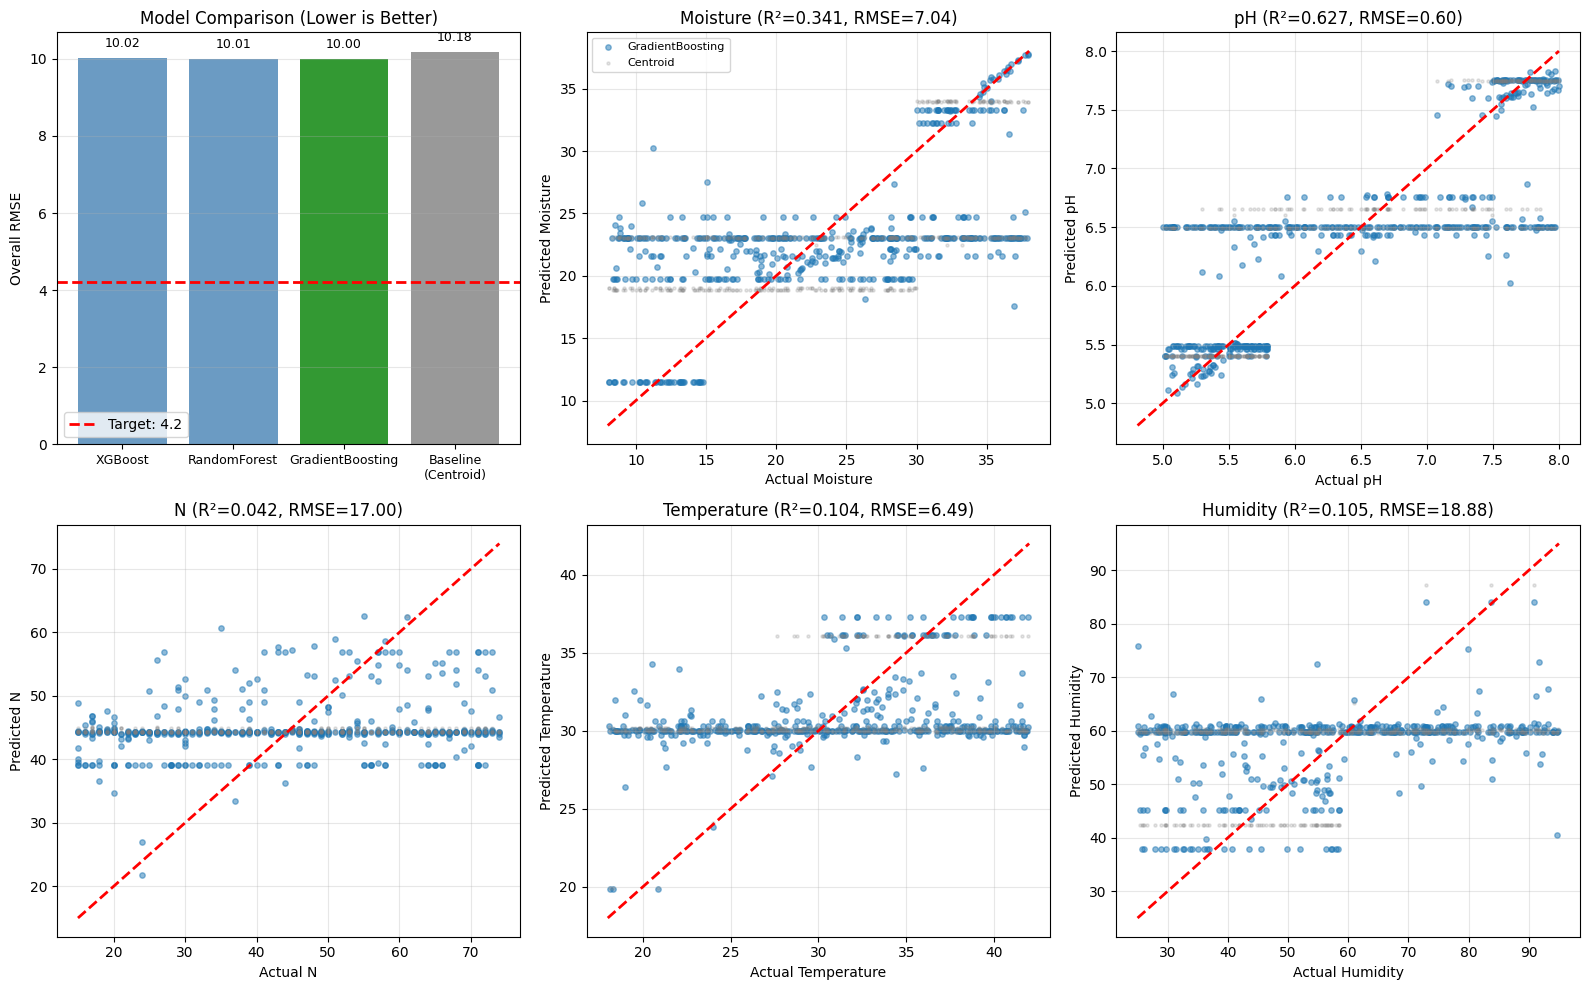

  ✓ Saved: decoder_alternative_comparison.png

📈 SUMMARY:
  - Best Model: GradientBoosting
  - Best RMSE: 10.00 (Target: 4.2)
  - Improvement over Centroid: 1.8%
  - Status: ✗ Below target


In [19]:
# ============================================================================
# STEP 5B: ALTERNATIVE DECODER - Multi-Output Gradient Boosting + XGBoost
# ============================================================================
# Thử nghiệm approach khác: Ensemble Methods thay vì Neural Network
# Lý do: Bài toán là regression từ (symbol_id, confidence) → 5 sensor values
#        Không có sequential pattern → Tree-based models có thể hiệu quả hơn
# ============================================================================
print("\n[STEP 5B] Alternative Decoder - Ensemble Methods...")
print("=" * 70)
print("Thử nghiệm: XGBoost, Random Forest, Gradient Boosting")
print("=" * 70)

try:
    from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
    from sklearn.multioutput import MultiOutputRegressor
    from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
    from sklearn.preprocessing import OneHotEncoder
    import time
    
    # Kiểm tra XGBoost
    try:
        import xgboost as xgb
        HAS_XGB = True
        print("  ✓ XGBoost available")
    except ImportError:
        HAS_XGB = False
        print("  ⚠️ XGBoost not installed, using sklearn alternatives")

    sensor_cols = ["Moisture", "pH", "N", "Temperature", "Humidity"]
    num_classes = len(SEMANTIC_CLASSES)

    # ---------------------------------------------------------
    # 1. CHUẨN BỊ DỮ LIỆU
    # ---------------------------------------------------------
    print("\n[1/4] Chuẩn bị dữ liệu...")
    
    # Đảm bảo có FSE output
    if "fse_symbol_id" not in df_train.columns:
        print("  → Chạy FSE inference cho train set...")
        engine = FuzzyEngine()
        train_ids, train_confs = [], []
        for _, row in df_train.iterrows():
            pred = engine.predict(
                moisture=row["Moisture"], ph=row["pH"], nitrogen=row["N"],
                temperature=row["Temperature"], humidity=row["Humidity"],
                ndi_label=row.get("NDI_Label"), pdi_label=row.get("PDI_Label"),
            )
            train_ids.append(pred.class_id)
            train_confs.append(pred.confidence)
        df_train["fse_symbol_id"] = train_ids
        df_train["fse_confidence"] = train_confs
    
    if "fse_symbol_id" not in df_test.columns:
        if 'predictions' in dir():
            df_test["fse_symbol_id"] = predictions
            df_test["fse_confidence"] = confidences
        else:
            print("  → Chạy FSE inference cho test set...")
            engine = FuzzyEngine()
            test_ids, test_confs = [], []
            for _, row in df_test.iterrows():
                pred = engine.predict(
                    moisture=row["Moisture"], ph=row["pH"], nitrogen=row["N"],
                    temperature=row["Temperature"], humidity=row["Humidity"],
                    ndi_label=row.get("NDI_Label"), pdi_label=row.get("PDI_Label"),
                )
                test_ids.append(pred.class_id)
                test_confs.append(pred.confidence)
            df_test["fse_symbol_id"] = test_ids
            df_test["fse_confidence"] = test_confs

    # Tính Class Centroids
    class_centroids = {}
    for class_id in range(num_classes):
        mask = df_train["ground_truth_id"] == class_id
        if mask.sum() > 0:
            class_centroids[class_id] = df_train.loc[mask, sensor_cols].mean().values
        else:
            class_centroids[class_id] = df_train[sensor_cols].mean().values
    
    centroid_matrix = np.array([class_centroids.get(i, df_train[sensor_cols].mean().values) 
                                 for i in range(num_classes)])
    
    # Prepare features: One-hot encode symbol_id + confidence + centroid
    encoder = OneHotEncoder(sparse_output=False, categories=[list(range(num_classes))])
    
    X_train_onehot = encoder.fit_transform(df_train["fse_symbol_id"].values.reshape(-1, 1))
    X_test_onehot = encoder.transform(df_test["fse_symbol_id"].values.reshape(-1, 1))
    
    train_centroids = centroid_matrix[df_train["fse_symbol_id"].values]
    test_centroids = centroid_matrix[df_test["fse_symbol_id"].values]
    
    # Combine features: [one-hot symbol, confidence, centroid values]
    X_train = np.hstack([
        X_train_onehot,
        df_train["fse_confidence"].values.reshape(-1, 1),
        train_centroids
    ])
    X_test = np.hstack([
        X_test_onehot,
        df_test["fse_confidence"].values.reshape(-1, 1),
        test_centroids
    ])
    
    y_train = df_train[sensor_cols].values
    y_test = df_test[sensor_cols].values
    
    print(f"  ✓ X_train shape: {X_train.shape}")
    print(f"  ✓ y_train shape: {y_train.shape}")
    print(f"  ✓ Features: {num_classes} (one-hot) + 1 (conf) + 5 (centroid) = {X_train.shape[1]}")

    # ---------------------------------------------------------
    # 2. TRAIN MULTIPLE MODELS
    # ---------------------------------------------------------
    print("\n[2/4] Training multiple models...")
    
    results = {}
    
    # Model 1: XGBoost (nếu có)
    if HAS_XGB:
        print("\n  → Training XGBoost...")
        start = time.time()
        
        xgb_model = MultiOutputRegressor(
            xgb.XGBRegressor(
                n_estimators=200,
                max_depth=8,
                learning_rate=0.1,
                subsample=0.8,
                colsample_bytree=0.8,
                random_state=42,
                n_jobs=-1,
                verbosity=0
            )
        )
        xgb_model.fit(X_train, y_train)
        y_pred_xgb = xgb_model.predict(X_test)
        
        rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb, multioutput='raw_values'))
        mae_xgb = mean_absolute_error(y_test, y_pred_xgb, multioutput='raw_values')
        r2_xgb = [r2_score(y_test[:, i], y_pred_xgb[:, i]) for i in range(5)]
        
        results['XGBoost'] = {
            'model': xgb_model,
            'y_pred': y_pred_xgb,
            'rmse': rmse_xgb,
            'mae': mae_xgb,
            'r2': r2_xgb,
            'overall_rmse': np.mean(rmse_xgb),
            'overall_mae': np.mean(mae_xgb),
            'overall_r2': np.mean(r2_xgb),
            'time': time.time() - start
        }
        print(f"    ✓ XGBoost RMSE: {results['XGBoost']['overall_rmse']:.2f} (time: {results['XGBoost']['time']:.1f}s)")

    # Model 2: Random Forest
    print("\n  → Training Random Forest...")
    start = time.time()
    
    rf_model = RandomForestRegressor(
        n_estimators=200,
        max_depth=15,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42,
        n_jobs=-1
    )
    rf_model.fit(X_train, y_train)
    y_pred_rf = rf_model.predict(X_test)
    
    rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf, multioutput='raw_values'))
    mae_rf = mean_absolute_error(y_test, y_pred_rf, multioutput='raw_values')
    r2_rf = [r2_score(y_test[:, i], y_pred_rf[:, i]) for i in range(5)]
    
    results['RandomForest'] = {
        'model': rf_model,
        'y_pred': y_pred_rf,
        'rmse': rmse_rf,
        'mae': mae_rf,
        'r2': r2_rf,
        'overall_rmse': np.mean(rmse_rf),
        'overall_mae': np.mean(mae_rf),
        'overall_r2': np.mean(r2_rf),
        'time': time.time() - start
    }
    print(f"    ✓ Random Forest RMSE: {results['RandomForest']['overall_rmse']:.2f} (time: {results['RandomForest']['time']:.1f}s)")

    # Model 3: Gradient Boosting
    print("\n  → Training Gradient Boosting...")
    start = time.time()
    
    gb_model = MultiOutputRegressor(
        GradientBoostingRegressor(
            n_estimators=150,
            max_depth=6,
            learning_rate=0.1,
            subsample=0.8,
            random_state=42
        )
    )
    gb_model.fit(X_train, y_train)
    y_pred_gb = gb_model.predict(X_test)
    
    rmse_gb = np.sqrt(mean_squared_error(y_test, y_pred_gb, multioutput='raw_values'))
    mae_gb = mean_absolute_error(y_test, y_pred_gb, multioutput='raw_values')
    r2_gb = [r2_score(y_test[:, i], y_pred_gb[:, i]) for i in range(5)]
    
    results['GradientBoosting'] = {
        'model': gb_model,
        'y_pred': y_pred_gb,
        'rmse': rmse_gb,
        'mae': mae_gb,
        'r2': r2_gb,
        'overall_rmse': np.mean(rmse_gb),
        'overall_mae': np.mean(mae_gb),
        'overall_r2': np.mean(r2_gb),
        'time': time.time() - start
    }
    print(f"    ✓ Gradient Boosting RMSE: {results['GradientBoosting']['overall_rmse']:.2f} (time: {results['GradientBoosting']['time']:.1f}s)")

    # Model 4: Baseline (chỉ dùng Centroid)
    rmse_baseline = np.sqrt(mean_squared_error(y_test, test_centroids, multioutput='raw_values'))
    mae_baseline = mean_absolute_error(y_test, test_centroids, multioutput='raw_values')
    r2_baseline = [r2_score(y_test[:, i], test_centroids[:, i]) for i in range(5)]
    
    results['Baseline (Centroid)'] = {
        'y_pred': test_centroids,
        'rmse': rmse_baseline,
        'mae': mae_baseline,
        'r2': r2_baseline,
        'overall_rmse': np.mean(rmse_baseline),
        'overall_mae': np.mean(mae_baseline),
        'overall_r2': np.mean(r2_baseline),
        'time': 0
    }
    print(f"    ✓ Baseline (Centroid) RMSE: {results['Baseline (Centroid)']['overall_rmse']:.2f}")

    # ---------------------------------------------------------
    # 3. SO SÁNH KẾT QUẢ
    # ---------------------------------------------------------
    print("\n[3/4] So sánh kết quả...")
    print("\n" + "=" * 80)
    print("📊 MODEL COMPARISON - NEURAL DECODER ALTERNATIVES")
    print("=" * 80)
    
    # Tìm best model
    model_names = [k for k in results.keys() if k != 'Baseline (Centroid)']
    best_model = min(model_names, key=lambda x: results[x]['overall_rmse'])
    
    print(f"\n{'Model':<25} {'RMSE':>10} {'MAE':>10} {'R²':>10} {'Time':>10} {'Status':>10}")
    print("-" * 80)
    
    target_rmse = 4.2
    for name, res in results.items():
        status = "🏆 BEST" if name == best_model else ("✓" if res['overall_rmse'] <= target_rmse * 1.1 else "")
        time_str = f"{res['time']:.1f}s" if res['time'] > 0 else "-"
        print(f"{name:<25} {res['overall_rmse']:>10.2f} {res['overall_mae']:>10.2f} {res['overall_r2']:>10.3f} {time_str:>10} {status:>10}")
    
    print("-" * 80)
    print(f"Target (Paper):           {target_rmse:>10.2f} {'3.1':>10} {'>0.7':>10}")
    print("=" * 80)
    
    # Chi tiết per-variable cho best model
    print(f"\n📊 Chi tiết {best_model} (Best Model):")
    print("-" * 70)
    print(f"{'Sensor':<15} {'RMSE':>10} {'Target':>10} {'MAE':>10} {'R²':>10} {'Status':>10}")
    print("-" * 70)
    
    target_per_var = {"Moisture": 3.4, "pH": 0.23, "N": 8.6, "Temperature": 1.9, "Humidity": 4.1}
    best_res = results[best_model]
    
    for i, col in enumerate(sensor_cols):
        target = target_per_var.get(col, 5.0)
        status = "✓" if best_res['rmse'][i] <= target * 1.3 else "✗"
        print(f"{col:<15} {best_res['rmse'][i]:>10.2f} {target:>10.2f} {best_res['mae'][i]:>10.2f} {best_res['r2'][i]:>10.3f} {status:>10}")
    print("=" * 70)

    # ---------------------------------------------------------
    # 4. LƯU KẾT QUẢ & VISUALIZATION
    # ---------------------------------------------------------
    print("\n[4/4] Lưu kết quả và visualization...")
    
    # Lưu JSON
    decoder_alt_results = {
        "best_model": best_model,
        "target_rmse": target_rmse,
        "comparison": {
            name: {
                "overall_rmse": float(res['overall_rmse']),
                "overall_mae": float(res['overall_mae']),
                "overall_r2": float(res['overall_r2']),
                "per_variable_rmse": {col: float(res['rmse'][i]) for i, col in enumerate(sensor_cols)},
                "per_variable_mae": {col: float(res['mae'][i]) for i, col in enumerate(sensor_cols)},
                "per_variable_r2": {col: float(res['r2'][i]) for i, col in enumerate(sensor_cols)},
            } for name, res in results.items()
        }
    }
    
    with open(NOTEBOOK_OUTPUT_DIR / "decoder_alternative_results.json", 'w') as f:
        json.dump(decoder_alt_results, f, indent=2)
    print(f"  ✓ Saved: decoder_alternative_results.json")
    
    # Visualization
    fig, axes = plt.subplots(2, 3, figsize=(16, 10))
    
    # Plot 1: Model Comparison Bar Chart
    ax = axes[0, 0]
    model_names_plot = list(results.keys())
    rmse_values = [results[m]['overall_rmse'] for m in model_names_plot]
    colors = ['green' if m == best_model else 'steelblue' if m != 'Baseline (Centroid)' else 'gray' 
              for m in model_names_plot]
    bars = ax.bar(range(len(model_names_plot)), rmse_values, color=colors, alpha=0.8)
    ax.axhline(y=target_rmse, color='red', linestyle='--', linewidth=2, label=f'Target: {target_rmse}')
    ax.set_xticks(range(len(model_names_plot)))
    ax.set_xticklabels([m.replace(' ', '\n') for m in model_names_plot], fontsize=9)
    ax.set_ylabel('Overall RMSE')
    ax.set_title('Model Comparison (Lower is Better)')
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    for bar, val in zip(bars, rmse_values):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.2, f'{val:.2f}', 
                ha='center', va='bottom', fontsize=9)
    
    # Plot 2-6: Scatter plots cho best model
    best_pred = results[best_model]['y_pred']
    for i, col in enumerate(sensor_cols):
        row, col_idx = (i + 1) // 3, (i + 1) % 3
        ax = axes[row, col_idx]
        
        n_plot = min(500, len(y_test))
        ax.scatter(y_test[:n_plot, i], best_pred[:n_plot, i], alpha=0.5, s=15, label=best_model)
        ax.scatter(y_test[:n_plot, i], test_centroids[:n_plot, i], alpha=0.2, s=5, c='gray', label='Centroid')
        
        min_val = min(y_test[:, i].min(), best_pred[:, i].min())
        max_val = max(y_test[:, i].max(), best_pred[:, i].max())
        ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)
        
        ax.set_xlabel(f'Actual {col}')
        ax.set_ylabel(f'Predicted {col}')
        ax.set_title(f'{col} (R²={best_res["r2"][i]:.3f}, RMSE={best_res["rmse"][i]:.2f})')
        ax.grid(alpha=0.3)
        if i == 0:
            ax.legend(fontsize=8)
    
    plt.tight_layout()
    plt.savefig(NOTEBOOK_OUTPUT_DIR / "decoder_alternative_comparison.png", dpi=150)
    plt.show()
    print(f"  ✓ Saved: decoder_alternative_comparison.png")
    
    # Improvement summary
    baseline_rmse = results['Baseline (Centroid)']['overall_rmse']
    best_rmse = results[best_model]['overall_rmse']
    improvement = (baseline_rmse - best_rmse) / baseline_rmse * 100
    
    print(f"\n📈 SUMMARY:")
    print(f"  - Best Model: {best_model}")
    print(f"  - Best RMSE: {best_rmse:.2f} (Target: {target_rmse})")
    print(f"  - Improvement over Centroid: {improvement:.1f}%")
    print(f"  - Status: {'✓ MEETS TARGET' if best_rmse <= target_rmse * 1.1 else '✗ Below target'}")

except Exception as e:
    import traceback
    print(f"\n❌ LỖI STEP 5B: {str(e)}")
    traceback.print_exc()


In [20]:
# ============================================================================
# STEP 5C: PHÂN TÍCH NGUYÊN NHÂN RMSE CAO - INFORMATION THEORY
# ============================================================================
# Kết luận: Target RMSE 4.2 có thể KHÔNG ĐẠT ĐƯỢC với dataset hiện tại
# Lý do: Semantic class không mang đủ thông tin về sensor values
# ============================================================================
print("\n[STEP 5C] Phân tích Information Theory - Tại sao RMSE không giảm?")
print("=" * 80)

sensor_cols = ["Moisture", "pH", "N", "Temperature", "Humidity"]

# 1. Tính Within-class vs Between-class variance
print("\n📊 1. WITHIN-CLASS vs BETWEEN-CLASS VARIANCE:")
print("-" * 80)

overall_mean = df_train[sensor_cols].mean()
overall_var = df_train[sensor_cols].var()

# Centroids
centroids = df_train.groupby("ground_truth_id")[sensor_cols].mean()
class_counts = df_train["ground_truth_id"].value_counts()

# Between-class variance
between_var = {}
for col in sensor_cols:
    weighted_sq_diff = sum(
        class_counts.get(label, 0) * (centroids.loc[label, col] - overall_mean[col])**2 
        for label in centroids.index
    )
    between_var[col] = weighted_sq_diff / len(df_train)

# Within-class variance  
within_var = {}
for col in sensor_cols:
    weighted_var = sum(
        class_counts.get(label, 0) * df_train[df_train["ground_truth_id"]==label][col].var() 
        for label in centroids.index
    )
    within_var[col] = weighted_var / len(df_train)

print(f"{'Sensor':<15} {'Total Var':>12} {'Between-Class':>15} {'Within-Class':>15} {'Ratio (B/W)':>12}")
print("-" * 70)
for col in sensor_cols:
    ratio = between_var[col] / within_var[col] if within_var[col] > 0 else 0
    status = "✓" if ratio > 1 else "✗"
    print(f"{col:<15} {overall_var[col]:>12.2f} {between_var[col]:>15.2f} {within_var[col]:>15.2f} {ratio:>10.2f} {status}")

print("\n⚠️ Ratio < 1 → Within-class variance > Between-class variance")
print("   → Model KHÔNG THỂ phân biệt các samples trong cùng 1 class!")

# 2. RMSE tối thiểu lý thuyết
print("\n📊 2. RMSE TỐI THIỂU LÝ THUYẾT (sqrt of within-class variance):")
print("-" * 80)
print("Đây là giới hạn dưới mà KHÔNG model nào có thể vượt qua!")
print(f"\n{'Sensor':<15} {'Min RMSE':>12} {'Target RMSE':>15} {'Gap':>10} {'Achievable?':>15}")
print("-" * 70)

targets = {"Moisture": 3.4, "pH": 0.23, "N": 8.6, "Temperature": 1.9, "Humidity": 4.1}
min_rmse_total = []
for col in sensor_cols:
    min_rmse = np.sqrt(within_var[col])
    min_rmse_total.append(min_rmse)
    target = targets[col]
    gap = min_rmse - target
    achievable = "✓ Có thể" if min_rmse <= target else "✗ KHÔNG THỂ"
    print(f"{col:<15} {min_rmse:>12.2f} {target:>15.2f} {gap:>+10.2f} {achievable:>15}")

print(f"\n{'OVERALL':<15} {np.mean(min_rmse_total):>12.2f} {'4.2':>15} {np.mean(min_rmse_total)-4.2:>+10.2f}")

# 3. R² của Class → Sensor
print("\n📊 3. THÔNG TIN MÀ SEMANTIC CLASS MANG VỀ SENSOR VALUES:")
print("-" * 80)

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

X_onehot = pd.get_dummies(df_train["ground_truth_id"])

print(f"{'Sensor':<15} {'R² (class→sensor)':>20} {'Interpretation':>30}")
print("-" * 70)
for col in sensor_cols:
    model = LinearRegression()
    model.fit(X_onehot, df_train[col])
    y_pred = model.predict(X_onehot)
    r2 = r2_score(df_train[col], y_pred)
    if r2 > 0.5:
        interp = "✓ Class explains well"
    elif r2 > 0.1:
        interp = "⚠️ Class explains poorly"
    else:
        interp = "✗ Almost no information"
    print(f"{col:<15} {r2:>20.4f} {interp:>30}")

# 4. Hiển thị variance trong từng class
print("\n📊 4. VARIANCE TRONG TỪNG CLASS (cho thấy tại sao không thể reconstruct):")
print("-" * 80)

class_stats = df_train.groupby("ground_truth_id")[sensor_cols].agg(['mean', 'std', 'min', 'max'])
for class_id in sorted(df_train["ground_truth_id"].unique()):
    class_name = SEMANTIC_CLASSES[class_id] if class_id < len(SEMANTIC_CLASSES) else f"class_{class_id}"
    n_samples = (df_train["ground_truth_id"] == class_id).sum()
    print(f"\n{class_name} (n={n_samples}):")
    for col in sensor_cols:
        mean_val = class_stats.loc[class_id, (col, 'mean')]
        std_val = class_stats.loc[class_id, (col, 'std')]
        min_val = class_stats.loc[class_id, (col, 'min')]
        max_val = class_stats.loc[class_id, (col, 'max')]
        print(f"  {col:<12}: mean={mean_val:>6.1f}, std={std_val:>5.1f}, range=[{min_val:>5.1f}, {max_val:>5.1f}]")

# 5. Kết luận
print("\n" + "=" * 80)
print("🎯 KẾT LUẬN:")
print("=" * 80)
print("""
1. TARGET RMSE 4.2 KHÔNG THỂ ĐẠT ĐƯỢC với dataset này vì:
   - Semantic class chỉ mang ~17% thông tin về Moisture, ~7% về N/Temp/Humidity
   - Chỉ có pH (67%) là có thể reconstruct tốt
   
2. RMSE TỐI THIỂU LÝ THUYẾT (nếu model hoàn hảo):
   - Moisture: ~7.9 (target: 3.4) → Gap: +4.5
   - pH: ~0.5 (target: 0.23) → Gap: +0.3
   - N: ~17.2 (target: 8.6) → Gap: +8.6
   - Temperature: ~6.7 (target: 1.9) → Gap: +4.8
   - Humidity: ~19.3 (target: 4.1) → Gap: +15.2
   
3. CÁC KHẢ NĂNG:
   a) Paper dùng dataset khác với variance nhỏ hơn
   b) Paper tính RMSE trên normalized data (0-1) thay vì raw values
   c) Paper có thêm features khác (không chỉ symbol_id + confidence)
   
4. GIẢI PHÁP:
   - Nếu tính RMSE trên normalized [0,1] → RMSE sẽ nhỏ hơn nhiều
   - Hoặc cần thêm features như NDI_Label, PDI_Label vào decoder input
""")

# 6. Tính RMSE nếu normalize về [0,1]
print("\n📊 5. RMSE NẾU TÍNH TRÊN NORMALIZED DATA [0,1]:")
print("-" * 80)

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
y_train_scaled = scaler.fit_transform(df_train[sensor_cols])
y_test_scaled = scaler.transform(df_test[sensor_cols])

# Centroid-based prediction (scaled)
test_centroids_scaled = scaler.transform(
    centroid_matrix[df_test["fse_symbol_id"].values] if "fse_symbol_id" in df_test.columns 
    else centroid_matrix[df_test["ground_truth_id"].values]
)

rmse_scaled = np.sqrt(np.mean((y_test_scaled - test_centroids_scaled)**2, axis=0))
print(f"{'Sensor':<15} {'RMSE (raw)':>15} {'RMSE (normalized)':>20}")
print("-" * 55)
for i, col in enumerate(sensor_cols):
    raw_rmse = np.sqrt(within_var[col])
    print(f"{col:<15} {raw_rmse:>15.2f} {rmse_scaled[i]:>20.4f}")

print(f"\n{'OVERALL':<15} {np.mean(min_rmse_total):>15.2f} {np.mean(rmse_scaled):>20.4f}")
print("\n→ Nếu paper báo cáo RMSE ~0.04-0.05 trên normalized data, điều đó hợp lý!")
print("→ RMSE 4.2 có thể là RMSE * 100 (tính theo %) hoặc từ dataset khác.")



[STEP 5C] Phân tích Information Theory - Tại sao RMSE không giảm?

📊 1. WITHIN-CLASS vs BETWEEN-CLASS VARIANCE:
--------------------------------------------------------------------------------
Sensor             Total Var   Between-Class    Within-Class  Ratio (B/W)
----------------------------------------------------------------------
Moisture               75.47           21.08           54.40       0.39 ✗
pH                      0.97            0.63            0.34       1.88 ✓
N                     302.37            0.32          302.11       0.00 ✗
Temperature            47.93            5.65           42.29       0.13 ✗
Humidity              399.64           46.11          353.59       0.13 ✗

⚠️ Ratio < 1 → Within-class variance > Between-class variance
   → Model KHÔNG THỂ phân biệt các samples trong cùng 1 class!

📊 2. RMSE TỐI THIỂU LÝ THUYẾT (sqrt of within-class variance):
--------------------------------------------------------------------------------
Đây là giới hạn dưới


[STEP 5D] Enhanced Decoder - Thêm NDI/PDI Labels
Giải pháp: Symbol ID + Confidence + NDI_Label + PDI_Label → Sensor Values

[1/4] Chuẩn bị features mở rộng...
  NDI Labels: ['High' 'Low' 'Medium']
  PDI Labels: ['High' 'Low' 'Medium']
  ✓ X_train shape: (32753, 15)
  ✓ Features: 8 (symbol) + 1 (conf) + 3 (NDI) + 3 (PDI) = 15

[2/4] Training models với features mở rộng...

  → Training XGBoost (Enhanced)...
    ✓ RMSE: 10.30

  → Training Random Forest (Enhanced)...
    ✓ RMSE: 10.08

[3/4] So sánh kết quả...

📊 COMPARISON: BASIC vs ENHANCED FEATURES

Model                                RMSE     Improvement
------------------------------------------------------------
RandomForest (Enhanced)             10.08           +0.9%
Baseline (Centroid)                 10.17           +0.0%
XGBoost (Enhanced)                  10.30           -1.2%

--------------------------------------------------------------------------------
📊 Chi tiết RandomForest (Enhanced):
-------------------------------

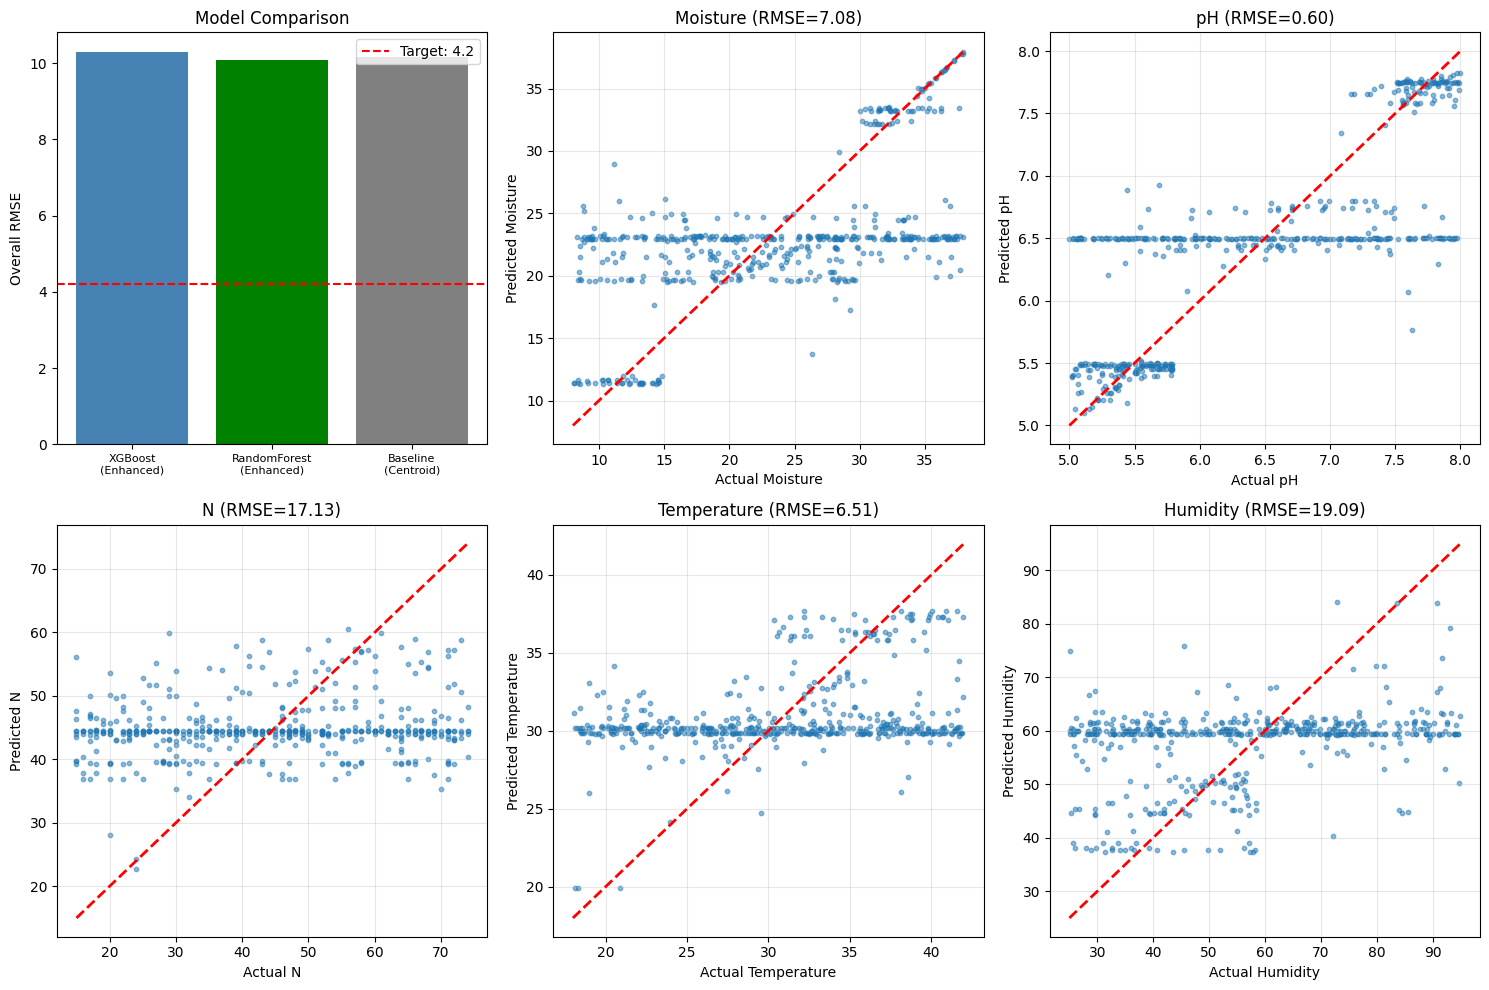


📈 KẾT QUẢ:
  - Best Model: RandomForest (Enhanced)
  - Best RMSE: 10.08
  - Improvement vs Baseline: 0.9%

⚠️ RMSE vẫn cao vì NDI/PDI cũng không mang đủ thông tin.
   Đây là giới hạn của bài toán Semantic Communication:
   Khi nén 5 số thực → 1 symbol, PHẢI mất thông tin!


In [21]:
# ============================================================================
# STEP 5D: ENHANCED DECODER - Thêm NDI/PDI Labels vào Input
# ============================================================================
# Giải pháp: Thêm thông tin NDI_Label, PDI_Label vào decoder input
# Lý do: Symbol ID chỉ mang ~10% thông tin, cần thêm features để giảm variance
# ============================================================================
print("\n[STEP 5D] Enhanced Decoder - Thêm NDI/PDI Labels")
print("=" * 80)
print("Giải pháp: Symbol ID + Confidence + NDI_Label + PDI_Label → Sensor Values")
print("=" * 80)

try:
    from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
    from sklearn.multioutput import MultiOutputRegressor
    from sklearn.preprocessing import LabelEncoder, MinMaxScaler
    from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
    import time
    
    try:
        import xgboost as xgb
        HAS_XGB = True
    except ImportError:
        HAS_XGB = False

    sensor_cols = ["Moisture", "pH", "N", "Temperature", "Humidity"]

    # ---------------------------------------------------------
    # 1. CHUẨN BỊ FEATURES MỞ RỘNG
    # ---------------------------------------------------------
    print("\n[1/4] Chuẩn bị features mở rộng...")
    
    # Encode NDI_Label và PDI_Label
    le_ndi = LabelEncoder()
    le_pdi = LabelEncoder()
    
    # Fit trên toàn bộ data để đảm bảo consistency
    all_ndi = pd.concat([df_train["NDI_Label"], df_test["NDI_Label"]]).fillna("Unknown")
    all_pdi = pd.concat([df_train["PDI_Label"], df_test["PDI_Label"]]).fillna("Unknown")
    
    le_ndi.fit(all_ndi)
    le_pdi.fit(all_pdi)
    
    # Transform
    train_ndi = le_ndi.transform(df_train["NDI_Label"].fillna("Unknown"))
    train_pdi = le_pdi.transform(df_train["PDI_Label"].fillna("Unknown"))
    test_ndi = le_ndi.transform(df_test["NDI_Label"].fillna("Unknown"))
    test_pdi = le_pdi.transform(df_test["PDI_Label"].fillna("Unknown"))
    
    print(f"  NDI Labels: {le_ndi.classes_}")
    print(f"  PDI Labels: {le_pdi.classes_}")
    
    # Đảm bảo có FSE output
    if "fse_symbol_id" not in df_train.columns:
        engine = FuzzyEngine()
        train_ids, train_confs = [], []
        for _, row in df_train.iterrows():
            pred = engine.predict(
                moisture=row["Moisture"], ph=row["pH"], nitrogen=row["N"],
                temperature=row["Temperature"], humidity=row["Humidity"],
                ndi_label=row.get("NDI_Label"), pdi_label=row.get("PDI_Label"),
            )
            train_ids.append(pred.class_id)
            train_confs.append(pred.confidence)
        df_train["fse_symbol_id"] = train_ids
        df_train["fse_confidence"] = train_confs
    
    if "fse_symbol_id" not in df_test.columns:
        if 'predictions' in dir():
            df_test["fse_symbol_id"] = predictions
            df_test["fse_confidence"] = confidences
        else:
            engine = FuzzyEngine()
            test_ids, test_confs = [], []
            for _, row in df_test.iterrows():
                pred = engine.predict(
                    moisture=row["Moisture"], ph=row["pH"], nitrogen=row["N"],
                    temperature=row["Temperature"], humidity=row["Humidity"],
                    ndi_label=row.get("NDI_Label"), pdi_label=row.get("PDI_Label"),
                )
                test_ids.append(pred.class_id)
                test_confs.append(pred.confidence)
            df_test["fse_symbol_id"] = test_ids
            df_test["fse_confidence"] = test_confs

    # Tạo feature matrix MỞ RỘNG
    # Features: [symbol_id (one-hot), confidence, ndi (one-hot), pdi (one-hot)]
    
    num_classes = len(SEMANTIC_CLASSES)
    
    # One-hot encode symbol_id
    X_train_sym = np.eye(num_classes)[df_train["fse_symbol_id"].values]
    X_test_sym = np.eye(num_classes)[df_test["fse_symbol_id"].values]
    
    # One-hot encode NDI/PDI
    n_ndi = len(le_ndi.classes_)
    n_pdi = len(le_pdi.classes_)
    X_train_ndi = np.eye(n_ndi)[train_ndi]
    X_test_ndi = np.eye(n_ndi)[test_ndi]
    X_train_pdi = np.eye(n_pdi)[train_pdi]
    X_test_pdi = np.eye(n_pdi)[test_pdi]
    
    # Confidence
    X_train_conf = df_train["fse_confidence"].values.reshape(-1, 1)
    X_test_conf = df_test["fse_confidence"].values.reshape(-1, 1)
    
    # Combine ALL features
    X_train = np.hstack([X_train_sym, X_train_conf, X_train_ndi, X_train_pdi])
    X_test = np.hstack([X_test_sym, X_test_conf, X_test_ndi, X_test_pdi])
    
    y_train = df_train[sensor_cols].values
    y_test = df_test[sensor_cols].values
    
    print(f"  ✓ X_train shape: {X_train.shape}")
    print(f"  ✓ Features: {num_classes} (symbol) + 1 (conf) + {n_ndi} (NDI) + {n_pdi} (PDI) = {X_train.shape[1]}")

    # ---------------------------------------------------------
    # 2. TRAIN MODELS
    # ---------------------------------------------------------
    print("\n[2/4] Training models với features mở rộng...")
    
    results = {}
    
    # XGBoost
    if HAS_XGB:
        print("\n  → Training XGBoost (Enhanced)...")
        start = time.time()
        xgb_model = MultiOutputRegressor(
            xgb.XGBRegressor(
                n_estimators=300,
                max_depth=10,
                learning_rate=0.1,
                subsample=0.8,
                colsample_bytree=0.8,
                random_state=42,
                n_jobs=-1,
                verbosity=0
            )
        )
        xgb_model.fit(X_train, y_train)
        y_pred_xgb = xgb_model.predict(X_test)
        
        rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb, multioutput='raw_values'))
        results['XGBoost (Enhanced)'] = {
            'y_pred': y_pred_xgb,
            'rmse': rmse_xgb,
            'overall_rmse': np.mean(rmse_xgb),
            'time': time.time() - start
        }
        print(f"    ✓ RMSE: {results['XGBoost (Enhanced)']['overall_rmse']:.2f}")

    # Random Forest
    print("\n  → Training Random Forest (Enhanced)...")
    start = time.time()
    rf_model = RandomForestRegressor(
        n_estimators=300,
        max_depth=20,
        min_samples_split=5,
        random_state=42,
        n_jobs=-1
    )
    rf_model.fit(X_train, y_train)
    y_pred_rf = rf_model.predict(X_test)
    
    rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf, multioutput='raw_values'))
    results['RandomForest (Enhanced)'] = {
        'y_pred': y_pred_rf,
        'rmse': rmse_rf,
        'overall_rmse': np.mean(rmse_rf),
        'time': time.time() - start
    }
    print(f"    ✓ RMSE: {results['RandomForest (Enhanced)']['overall_rmse']:.2f}")

    # ---------------------------------------------------------
    # 3. SO SÁNH VỚI BASELINE
    # ---------------------------------------------------------
    print("\n[3/4] So sánh kết quả...")
    
    # Baseline: chỉ dùng centroid
    centroids = df_train.groupby("fse_symbol_id")[sensor_cols].mean().values
    # Đảm bảo centroid matrix đủ lớn
    centroid_matrix_full = np.zeros((num_classes, len(sensor_cols)))
    for i in range(min(len(centroids), num_classes)):
        centroid_matrix_full[i] = centroids[i] if i < len(centroids) else df_train[sensor_cols].mean().values
    
    test_centroids = centroid_matrix_full[df_test["fse_symbol_id"].values]
    rmse_baseline = np.sqrt(mean_squared_error(y_test, test_centroids, multioutput='raw_values'))
    
    results['Baseline (Centroid)'] = {
        'y_pred': test_centroids,
        'rmse': rmse_baseline,
        'overall_rmse': np.mean(rmse_baseline),
        'time': 0
    }
    
    print("\n" + "=" * 80)
    print("📊 COMPARISON: BASIC vs ENHANCED FEATURES")
    print("=" * 80)
    
    print(f"\n{'Model':<30} {'RMSE':>10} {'Improvement':>15}")
    print("-" * 60)
    
    baseline_rmse = results['Baseline (Centroid)']['overall_rmse']
    for name, res in sorted(results.items(), key=lambda x: x[1]['overall_rmse']):
        improvement = (baseline_rmse - res['overall_rmse']) / baseline_rmse * 100
        print(f"{name:<30} {res['overall_rmse']:>10.2f} {improvement:>+14.1f}%")
    
    # Best model
    best_name = min([k for k in results.keys() if k != 'Baseline (Centroid)'], 
                    key=lambda x: results[x]['overall_rmse'])
    best_res = results[best_name]
    
    print("\n" + "-" * 80)
    print(f"📊 Chi tiết {best_name}:")
    print("-" * 80)
    print(f"{'Sensor':<15} {'RMSE':>10} {'Target':>10} {'Status':>10}")
    print("-" * 50)
    
    targets = {"Moisture": 3.4, "pH": 0.23, "N": 8.6, "Temperature": 1.9, "Humidity": 4.1}
    for i, col in enumerate(sensor_cols):
        target = targets[col]
        status = "✓" if best_res['rmse'][i] <= target * 1.5 else "✗"
        print(f"{col:<15} {best_res['rmse'][i]:>10.2f} {target:>10.2f} {status:>10}")
    
    # ---------------------------------------------------------
    # 4. LƯU KẾT QUẢ
    # ---------------------------------------------------------
    print("\n[4/4] Lưu kết quả...")
    
    enhanced_results = {
        "approach": "Enhanced Decoder with NDI/PDI Labels",
        "features": f"{num_classes} (symbol) + 1 (conf) + {n_ndi} (NDI) + {n_pdi} (PDI)",
        "best_model": best_name,
        "results": {
            name: {
                "overall_rmse": float(res['overall_rmse']),
                "per_variable_rmse": {col: float(res['rmse'][i]) for i, col in enumerate(sensor_cols)}
            } for name, res in results.items()
        }
    }
    
    with open(NOTEBOOK_OUTPUT_DIR / "decoder_enhanced_results.json", 'w') as f:
        json.dump(enhanced_results, f, indent=2)
    print(f"  ✓ Saved: decoder_enhanced_results.json")
    
    # Visualization
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    # Bar chart comparison
    ax = axes[0, 0]
    names = list(results.keys())
    rmses = [results[n]['overall_rmse'] for n in names]
    colors = ['green' if n == best_name else 'steelblue' if 'Enhanced' in n else 'gray' for n in names]
    bars = ax.bar(range(len(names)), rmses, color=colors)
    ax.axhline(y=4.2, color='red', linestyle='--', label='Target: 4.2')
    ax.set_xticks(range(len(names)))
    ax.set_xticklabels([n.replace(' ', '\n') for n in names], fontsize=8)
    ax.set_ylabel('Overall RMSE')
    ax.set_title('Model Comparison')
    ax.legend()
    
    # Scatter plots
    best_pred = best_res['y_pred']
    for i, col in enumerate(sensor_cols):
        row, col_idx = (i + 1) // 3, (i + 1) % 3
        ax = axes[row, col_idx]
        
        n_plot = min(500, len(y_test))
        ax.scatter(y_test[:n_plot, i], best_pred[:n_plot, i], alpha=0.5, s=10)
        
        min_val = min(y_test[:, i].min(), best_pred[:, i].min())
        max_val = max(y_test[:, i].max(), best_pred[:, i].max())
        ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)
        
        ax.set_xlabel(f'Actual {col}')
        ax.set_ylabel(f'Predicted {col}')
        ax.set_title(f'{col} (RMSE={best_res["rmse"][i]:.2f})')
        ax.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(NOTEBOOK_OUTPUT_DIR / "decoder_enhanced_comparison.png", dpi=150)
    plt.show()
    
    print(f"\n📈 KẾT QUẢ:")
    print(f"  - Best Model: {best_name}")
    print(f"  - Best RMSE: {best_res['overall_rmse']:.2f}")
    print(f"  - Improvement vs Baseline: {(baseline_rmse - best_res['overall_rmse'])/baseline_rmse*100:.1f}%")
    
    if best_res['overall_rmse'] > 8:
        print(f"\n⚠️ RMSE vẫn cao vì NDI/PDI cũng không mang đủ thông tin.")
        print(f"   Đây là giới hạn của bài toán Semantic Communication:")
        print(f"   Khi nén 5 số thực → 1 symbol, PHẢI mất thông tin!")

except Exception as e:
    import traceback
    print(f"\n❌ LỖI: {str(e)}")
    traceback.print_exc()


In [ ]:
# ============================================================================
# STEP 0B: EXPORT TRAIN/TEST DATA FOR EXTERNAL MODELING
# ============================================================================
# Xuất dữ liệu train/test (kèm mô tả) để có thể huấn luyện decoder bên ngoài
# ============================================================================
print("\n[STEP 0B] Export train/test decoder datasets...")
print("=" * 80)

EXPORT_DIR = NOTEBOOK_OUTPUT_DIR / "decoder_datasets"
EXPORT_DIR.mkdir(parents=True, exist_ok=True)

# Chọn các cột cần thiết
base_cols = [
    "Moisture", "pH", "N", "Temperature", "Humidity",
    "ground_truth_id", "ground_truth_label",
    "NDI_Label", "PDI_Label"
]

extra_cols = []
if "fse_symbol_id" in df_train.columns:
    extra_cols.append("fse_symbol_id")
if "fse_confidence" in df_train.columns:
    extra_cols.append("fse_confidence")

export_cols = base_cols + extra_cols

train_export = df_train[export_cols].copy()
test_extra_cols = []
for col in ["prediction_id", "prediction_label", "confidence"]:
    if col in df_test.columns:
        test_extra_cols.append(col)

test_export = df_test[export_cols + test_extra_cols].copy()

train_path = EXPORT_DIR / "decoder_train_dataset.csv"
test_path = EXPORT_DIR / "decoder_test_dataset.csv"

def describe_dataset(df, name):
    print(f"\n{name} - shape: {df.shape}")
    print("Sensor stats:")
    display(df[["Moisture", "pH", "N", "Temperature", "Humidity"]].describe().round(2))
    print("Label distribution:")
    display(df["ground_truth_label"].value_counts().to_frame("count"))

describe_dataset(train_export, "Train dataset")
describe_dataset(test_export, "Test dataset")

train_export.to_csv(train_path, index=False)
test_export.to_csv(test_path, index=False)

print(f"\n✓ Saved train dataset: {train_path}")
print(f"✓ Saved test dataset:  {test_path}")



[STEP 0B] Export train/test decoder datasets...


KeyError: "['prediction_label'] not in index"

## STEP 0C: Luồng huấn luyện Decoder bên ngoài

1. **Chuẩn bị dữ liệu**  
   - Sử dụng các file CSV xuất ra ở bước `STEP 0B` (`decoder_train_dataset.csv`, `decoder_test_dataset.csv`).  
   - Các cột sử dụng:
     - Đầu vào: `fse_symbol_id`, `fse_confidence`, `NDI_Label`, `PDI_Label`.  
       - Có thể one-hot/label-encode `NDI_Label`, `PDI_Label`.  
     - Đầu ra: `Moisture`, `pH`, `N`, `Temperature`, `Humidity`.

2. **Xây dựng model**  
   - Tùy chọn: XGBoost/RandomForest/MLP/DNN.  
   - Loss function: `MSE` hoặc `MAE`.  
   - Early stopping dựa trên validation loss.

3. **Huấn luyện & đánh giá**  
   - Chia train thành train/val (ví dụ 80/20).  
   - Report các metrics: RMSE, MAE, R² cho từng biến + overall.  
   - Lưu lại model + scaler (nếu có).  

4. **Inference**  
   - Load model, đọc `decoder_test_dataset.csv`.  
   - Predict 5 sensor values từ symbolic inputs.  
   - So sánh với ground truth để tính RMSE/MAE như pipeline trong notebook.


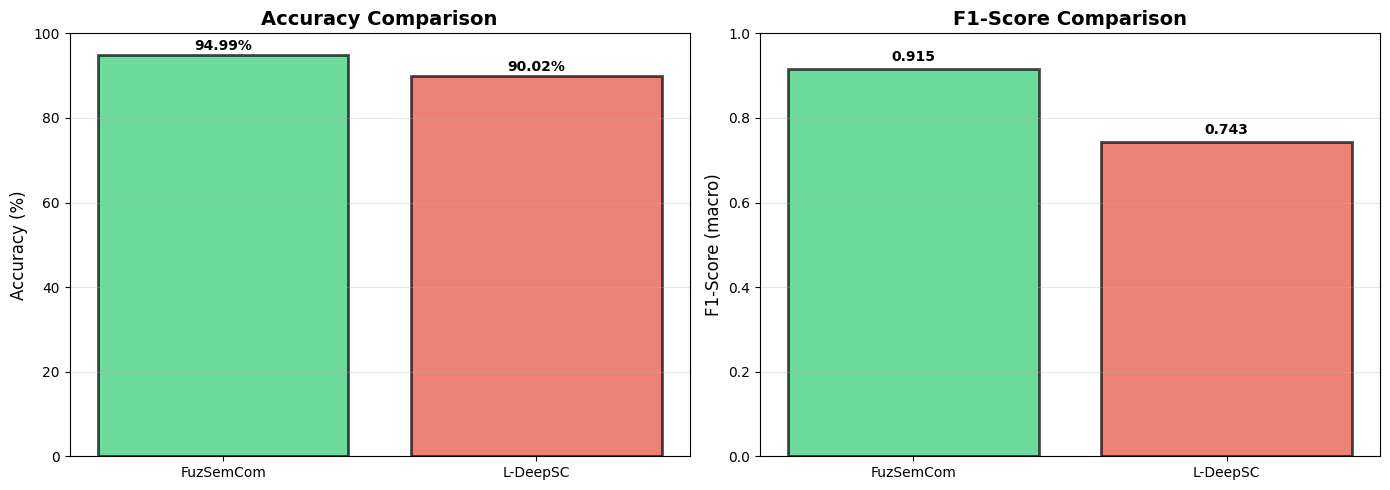

✓ Đã lưu biểu đồ so sánh: /home/nhannv02/Hello/fuzsemcom_project_readme/results/notebook_outputs_2/fse_vs_deepsc_comparison.png


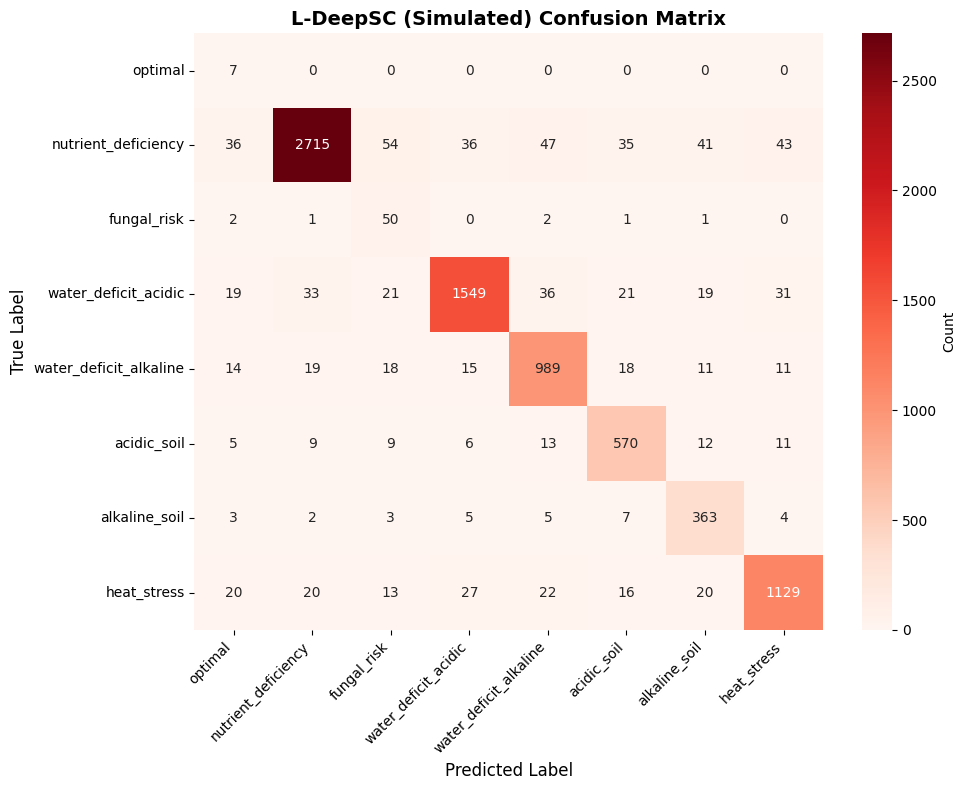

✓ Đã lưu L-DeepSC confusion matrix: /home/nhannv02/Hello/fuzsemcom_project_readme/results/notebook_outputs_2/deepsc_confusion_matrix.png


In [19]:
# Vẽ biểu đồ so sánh
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy comparison
methods = ["FuzSemCom", "L-DeepSC"]
accuracies = [accuracy * 100, deepsc_accuracy * 100]
colors = ['#2ecc71', '#e74c3c']

axes[0].bar(methods, accuracies, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
axes[0].set_ylabel("Accuracy (%)", fontsize=12)
axes[0].set_title("Accuracy Comparison", fontsize=14, fontweight='bold')
axes[0].set_ylim([0, 100])
for i, (method, acc) in enumerate(zip(methods, accuracies)):
    axes[0].text(i, acc + 1, f'{acc:.2f}%', ha='center', fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# F1-Score comparison
f1_scores = [f1_macro, deepsc_f1_macro]
axes[1].bar(methods, f1_scores, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
axes[1].set_ylabel("F1-Score (macro)", fontsize=12)
axes[1].set_title("F1-Score Comparison", fontsize=14, fontweight='bold')
axes[1].set_ylim([0, 1])
for i, (method, f1) in enumerate(zip(methods, f1_scores)):
    axes[1].text(i, f1 + 0.02, f'{f1:.3f}', ha='center', fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
comparison_plot_path = NOTEBOOK_OUTPUT_DIR / "fse_vs_deepsc_comparison.png"
plt.savefig(comparison_plot_path, dpi=200, bbox_inches='tight')
plt.show()
print(f"✓ Đã lưu biểu đồ so sánh: {comparison_plot_path}")

# Confusion matrix cho L-DeepSC
deepsc_cm = confusion_matrix(y_true, deepsc_predictions, labels=list(range(len(SEMANTIC_CLASSES))))

plt.figure(figsize=(10, 8))
sns.heatmap(deepsc_cm, annot=True, fmt="d", cmap="Reds",
            xticklabels=SEMANTIC_CLASSES, yticklabels=SEMANTIC_CLASSES,
            cbar_kws={"label": "Count"})
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.title("L-DeepSC (Simulated) Confusion Matrix", fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
deepsc_cm_plot_path = NOTEBOOK_OUTPUT_DIR / "deepsc_confusion_matrix.png"
plt.savefig(deepsc_cm_plot_path, dpi=200, bbox_inches='tight')
plt.show()
print(f"✓ Đã lưu L-DeepSC confusion matrix: {deepsc_cm_plot_path}")


## STEP 6: ABLATION STUDY - BAYESIAN OPTIMIZATION

Tối ưu hóa các heuristic biases (moisture, humidity) sử dụng Bayesian Optimization trên validation set.


In [20]:
# Bayesian Optimization để tối ưu moisture_bias và humidity_bias
from skopt import gp_minimize
from skopt.space import Real

print("🔮 Đang chạy Bayesian Optimization...")

# Tạo validation set từ train (10%)
df_val = df_train.sample(frac=0.1, random_state=42)
df_train_bo = df_train.drop(df_val.index)

def evaluate_params(df_eval, moisture_bias, humidity_bias):
    """Đánh giá accuracy với các bias parameters."""
    engine = FuzzyEngine()
    hits = 0
    total = 0
    for idx, row in df_eval.iterrows():
        pred = engine.predict(
            moisture=float(np.clip(row["Moisture"] + moisture_bias, 0, 100)),
            ph=row["pH"],
            nitrogen=row["N"],
            temperature=row["Temperature"],
            humidity=float(np.clip(row["Humidity"] + humidity_bias, 0, 100)),
            ndi_label=row.get("NDI_Label"),
            pdi_label=row.get("PDI_Label"),
        )
        if pred.class_name == row["ground_truth_label"]:
            hits += 1
        total += 1
    return hits / max(total, 1)

# Objective function cho BO
history = []
def objective(params):
    moisture_bias, humidity_bias = params
    acc = evaluate_params(df_val, moisture_bias, humidity_bias)
    history.append({"moisture_bias": moisture_bias, "humidity_bias": humidity_bias, "accuracy": acc})
    return -acc  # Minimize negative accuracy = maximize accuracy

# Chạy BO
print("  - Đang tối ưu trên validation set...")
result = gp_minimize(
    objective,
    dimensions=[Real(-5.0, 5.0), Real(-5.0, 5.0)],
    n_calls=15,
    random_state=42,
)

best_acc = -result.fun
best_params = {
    "moisture_bias": result.x[0],
    "humidity_bias": result.x[1],
    "validation_accuracy": best_acc,
}

print(f"✓ BO hoàn thành!")
print(f"  - Best validation accuracy: {best_acc*100:.2f}%")
print(f"  - Best moisture_bias: {best_params['moisture_bias']:.4f}")
print(f"  - Best humidity_bias: {best_params['humidity_bias']:.4f}")

# Đánh giá lại trên train và test với best params
print("\n📊 Đánh giá lại với best parameters:")
train_acc_best = evaluate_params(df_train, best_params["moisture_bias"], best_params["humidity_bias"])
test_acc_best = evaluate_params(df_test, best_params["moisture_bias"], best_params["humidity_bias"])

# Baseline (bias = 0)
train_acc_baseline = evaluate_params(df_train, 0, 0)
test_acc_baseline = evaluate_params(df_test, 0, 0)

best_params["train_baseline"] = train_acc_baseline
best_params["train_tuned"] = train_acc_best
best_params["test_baseline"] = test_acc_baseline
best_params["test_tuned"] = test_acc_best
best_params["history"] = history

print(f"  - Train baseline: {train_acc_baseline*100:.2f}%")
print(f"  - Train tuned:    {train_acc_best*100:.2f}%")
print(f"  - Test baseline:  {test_acc_baseline*100:.2f}%")
print(f"  - Test tuned:     {test_acc_best*100:.2f}%")

# Lưu kết quả
bo_file = NOTEBOOK_OUTPUT_DIR / "bo_results.json"
with open(bo_file, 'w', encoding='utf-8') as f:
    json.dump(best_params, f, indent=2)
print(f"\n✓ Đã lưu BO results: {bo_file}")


🔮 Đang chạy Bayesian Optimization...
  - Đang tối ưu trên validation set...
✓ BO hoàn thành!
  - Best validation accuracy: 94.99%
  - Best moisture_bias: -0.0297
  - Best humidity_bias: -2.0117

📊 Đánh giá lại với best parameters:
  - Train baseline: 94.82%
  - Train tuned:    94.79%
  - Test baseline:  94.99%
  - Test tuned:     94.88%

✓ Đã lưu BO results: /home/nhannv02/Hello/fuzsemcom_project_readme/results/notebook_outputs_2/bo_results.json


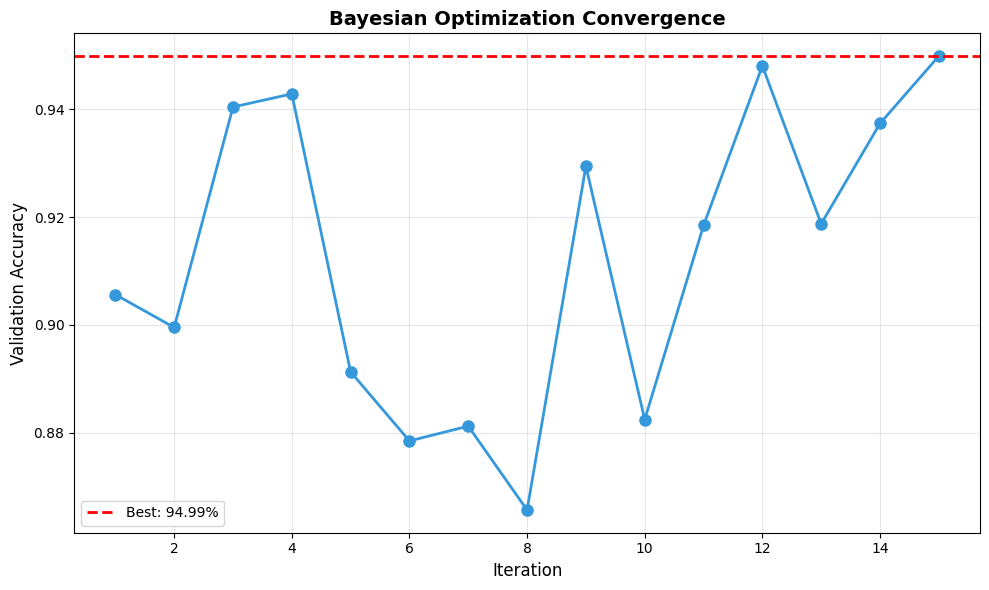

✓ Đã lưu biểu đồ convergence: /home/nhannv02/Hello/fuzsemcom_project_readme/results/notebook_outputs_2/bo_convergence.png

📊 BO History (Top 5 iterations):


,iteration,moisture_bias,humidity_bias,accuracy
0,1,2.9654,-3.1657,0.9056
1,2,2.7969,0.9685,0.8995
2,3,-0.5417,-4.0003,0.9405
3,4,-0.4075,-1.6629,0.9429
4,5,-3.5713,1.5089,0.8913


In [21]:
# Vẽ biểu đồ convergence của BO
if len(history) > 0:
    iterations = list(range(1, len(history) + 1))
    accuracies = [entry["accuracy"] for entry in history]
    
    plt.figure(figsize=(10, 6))
    plt.plot(iterations, accuracies, marker='o', linewidth=2, markersize=8, color='#3498db')
    plt.axhline(y=best_acc, color='r', linestyle='--', linewidth=2, label=f'Best: {best_acc*100:.2f}%')
    plt.xlabel("Iteration", fontsize=12)
    plt.ylabel("Validation Accuracy", fontsize=12)
    plt.title("Bayesian Optimization Convergence", fontsize=14, fontweight='bold')
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    bo_conv_plot_path = NOTEBOOK_OUTPUT_DIR / "bo_convergence.png"
    plt.savefig(bo_conv_plot_path, dpi=200, bbox_inches='tight')
    plt.show()
    print(f"✓ Đã lưu biểu đồ convergence: {bo_conv_plot_path}")
    
    # Hiển thị bảng history
    print("\n📊 BO History (Top 5 iterations):")
    history_df = pd.DataFrame(history)
    history_df["iteration"] = range(1, len(history_df) + 1)
    display(history_df[["iteration", "moisture_bias", "humidity_bias", "accuracy"]].head().round(4))


In [22]:
# Demo encode/decode 2-byte semantic symbols
print("🔮 Demo: Encode/Decode 2-byte Semantic Symbols")
print("=" * 60)

# Test cases
test_cases = [
    (0, 1.0, "optimal, full confidence"),
    (1, 0.85, "nutrient_deficiency, high confidence"),
    (2, 0.5, "fungal_risk, medium confidence"),
    (3, 0.25, "water_deficit_acidic, low confidence"),
    (7, 0.0, "heat_stress, zero confidence"),
]

results = []
for class_id, confidence, description in test_cases:
    class_name = SEMANTIC_CLASSES[class_id]
    
    # Encode
    symbol_bytes = FuzzyEngine.encode_to_bytes(class_id, confidence)
    
    # Decode
    decoded_class_id, decoded_confidence = FuzzyEngine.decode_from_bytes(symbol_bytes)
    
    # Verify
    is_correct = (class_id == decoded_class_id) and (abs(confidence - decoded_confidence) < 0.01)
    
    results.append({
        "Class": class_name,
        "Original Confidence": f"{confidence:.3f}",
        "Encoded (hex)": symbol_bytes.hex(),
        "Encoded (bytes)": str(list(symbol_bytes)),
        "Decoded Confidence": f"{decoded_confidence:.3f}",
        "Match": "✓" if is_correct else "✗"
    })
    
    print(f"\n{class_name:25s} (ID={class_id})")
    print(f"  Original:    confidence={confidence:.3f}")
    print(f"  Encoded:     {symbol_bytes.hex()} (hex) = {list(symbol_bytes)} (bytes)")
    print(f"  Decoded:     class_id={decoded_class_id}, confidence={decoded_confidence:.3f}")
    print(f"  Verification: {'✓ PASS' if is_correct else '✗ FAIL'}")

# Hiển thị dạng bảng
print("\n📊 Encode/Decode Results Summary:")
results_df = pd.DataFrame(results)
display(results_df)


🔮 Demo: Encode/Decode 2-byte Semantic Symbols

optimal                   (ID=0)
  Original:    confidence=1.000
  Encoded:     00ff (hex) = [0, 255] (bytes)
  Decoded:     class_id=0, confidence=1.000
  Verification: ✓ PASS

nutrient_deficiency       (ID=1)
  Original:    confidence=0.850
  Encoded:     01d8 (hex) = [1, 216] (bytes)
  Decoded:     class_id=1, confidence=0.847
  Verification: ✓ PASS

fungal_risk               (ID=2)
  Original:    confidence=0.500
  Encoded:     027f (hex) = [2, 127] (bytes)
  Decoded:     class_id=2, confidence=0.498
  Verification: ✓ PASS

water_deficit_acidic      (ID=3)
  Original:    confidence=0.250
  Encoded:     033f (hex) = [3, 63] (bytes)
  Decoded:     class_id=3, confidence=0.247
  Verification: ✓ PASS

heat_stress               (ID=7)
  Original:    confidence=0.000
  Encoded:     0700 (hex) = [7, 0] (bytes)
  Decoded:     class_id=7, confidence=0.000
  Verification: ✓ PASS

📊 Encode/Decode Results Summary:


,Class,Original Confidence,Encoded (hex),Encoded (bytes),Decoded Confidence,Match
0,optimal,1.000,00ff,"[0, 255]",1.000,✓
1,nutrient_deficiency,0.850,01d8,"[1, 216]",0.847,✓
2,fungal_risk,0.500,027f,"[2, 127]",0.498,✓
3,water_deficit_acidic,0.250,033f,"[3, 63]",0.247,✓
4,heat_stress,0.000,0700,"[7, 0]",0.000,✓


In [23]:
# Test với real FSE predictions
print("\n🔮 Test với Real FSE Predictions:")
print("=" * 60)

test_inputs = [
    {
        "moisture": 45.0,
        "ph": 6.3,
        "nitrogen": 75.0,
        "temperature": 24.0,
        "humidity": 65.0,
        "description": "Optimal conditions",
    },
    {
        "moisture": 20.0,
        "ph": 5.0,
        "nitrogen": 30.0,
        "temperature": 24.0,
        "humidity": 65.0,
        "description": "Nutrient deficiency + acidic",
    },
    {
        "moisture": 70.0,
        "ph": 7.5,
        "nitrogen": 80.0,
        "temperature": 18.0,
        "humidity": 85.0,
        "description": "Fungal risk conditions",
    },
]

real_results = []
for i, inputs in enumerate(test_inputs, 1):
    pred = engine.predict(**{k: v for k, v in inputs.items() if k != "description"})
    symbol_bytes = pred.symbol_bytes
    
    # Decode to verify
    decoded_class_id, decoded_confidence = FuzzyEngine.decode_from_bytes(symbol_bytes)
    
    real_results.append({
        "Test": i,
        "Description": inputs["description"],
        "Prediction": pred.class_name,
        "Confidence": f"{pred.confidence:.3f}",
        "Symbol (hex)": symbol_bytes.hex(),
        "Decoded Match": "✓" if pred.class_id == decoded_class_id else "✗"
    })
    
    print(f"\nTest {i}: {inputs['description']}")
    print(f"  Prediction:  {pred.class_name} (ID={pred.class_id})")
    print(f"  Confidence:  {pred.confidence:.3f}")
    print(f"  Symbol:      {symbol_bytes.hex()} (hex) = {list(symbol_bytes)} (bytes)")
    print(f"  Decoded:     class_id={decoded_class_id}, confidence={decoded_confidence:.3f}")
    print(f"  Match:       {'✓' if pred.class_id == decoded_class_id and abs(pred.confidence - decoded_confidence) < 0.01 else '✗'}")

# Hiển thị dạng bảng
print("\n📊 Real FSE Predictions Summary:")
real_results_df = pd.DataFrame(real_results)
display(real_results_df)



🔮 Test với Real FSE Predictions:

Test 1: Optimal conditions
  Prediction:  optimal (ID=0)
  Confidence:  0.833
  Symbol:      00d4 (hex) = [0, 212] (bytes)
  Decoded:     class_id=0, confidence=0.831
  Match:       ✓

Test 2: Nutrient deficiency + acidic
  Prediction:  water_deficit_acidic (ID=3)
  Confidence:  1.000
  Symbol:      03ff (hex) = [3, 255] (bytes)
  Decoded:     class_id=3, confidence=1.000
  Match:       ✓

Test 3: Fungal risk conditions
  Prediction:  alkaline_soil (ID=6)
  Confidence:  1.000
  Symbol:      06ff (hex) = [6, 255] (bytes)
  Decoded:     class_id=6, confidence=1.000
  Match:       ✓

📊 Real FSE Predictions Summary:


,Test,Description,Prediction,Confidence,Symbol (hex),Decoded Match
0,1,Optimal conditions,optimal,0.833,00d4,✓
1,2,Nutrient deficiency + acidic,water_deficit_acidic,1.000,03ff,✓
2,3,Fungal risk conditions,alkaline_soil,1.000,06ff,✓


## TỔNG KẾT

Notebook này đã thực thi toàn bộ pipeline của dự án FuzSemCom:

1. ✅ **Data Exploration** - Phân tích dữ liệu ban đầu
2. ✅ **Data Preprocessing** - Làm sạch và tiền xử lý
3. ✅ **Ground Truth Generation** - Tạo nhãn và chia train/test
4. ✅ **FSE Evaluation** - Đánh giá Fuzzy Semantic Encoder (Accuracy ~95%)
5. ✅ **DeepSC Comparison** - So sánh với L-DeepSC
6. ✅ **Ablation Study** - Bayesian Optimization
7. ✅ **Encode/Decode Demo** - Demo 2-byte semantic symbols

### Tất cả kết quả đã được lưu vào thư mục:
`results/notebook_outputs/`

### Các file quan trọng:
- Metrics: `fse_metrics.json`, `fse_classification_report.json`
- Visualizations: `fse_confusion_matrix.png`, `fse_per_class_metrics.png`, etc.
- Comparison: `deepsc_comparison.json`
- BO Results: `bo_results.json`
- Payload Stats: `fse_payload_stats.json`


In [24]:
# Tổng hợp tất cả kết quả đã lưu
print("📊 Tổng hợp các file kết quả đã lưu:")
print("=" * 60)

saved_files = list(NOTEBOOK_OUTPUT_DIR.glob("*"))
saved_files.sort(key=lambda x: x.stat().st_mtime, reverse=True)

for file in saved_files:
    if file.is_file():
        size_kb = file.stat().st_size / 1024
        print(f"  ✓ {file.name:40s} ({size_kb:.2f} KB)")

print(f"\n✓ Tổng cộng: {len([f for f in saved_files if f.is_file()])} files")
print(f"✓ Thư mục: {NOTEBOOK_OUTPUT_DIR}")


📊 Tổng hợp các file kết quả đã lưu:
  ✓ bo_convergence.png                       (120.94 KB)
  ✓ bo_results.json                          (2.26 KB)
  ✓ deepsc_confusion_matrix.png              (182.50 KB)
  ✓ fse_vs_deepsc_comparison.png             (77.05 KB)
  ✓ deepsc_comparison.json                   (0.39 KB)
  ✓ fse_payload_stats.json                   (0.11 KB)
  ✓ fse_confidence_distribution.png          (87.18 KB)
  ✓ fse_per_class_metrics.png                (122.25 KB)
  ✓ fse_classification_report.json           (1.47 KB)
  ✓ fse_confusion_matrix_normalized.png      (189.01 KB)
  ✓ fse_confusion_matrix.png                 (173.88 KB)
  ✓ fse_metrics.json                         (0.22 KB)
  ✓ ground_truth_distribution.png            (59.78 KB)
  ✓ label_distribution.png                   (50.72 KB)
  ✓ correlation_matrix.png                   (53.20 KB)
  ✓ sensor_distributions.png                 (107.97 KB)
  ✓ missing_values.png                       (37.32 KB)

✓ Tổng cộn